In [1]:
import pandas as pd
from sqlalchemy import create_engine
from datetime import datetime, timedelta

# 設置MySQL資料庫連接
db_user = 'root'
db_password = '19970730'
db_host = '127.0.0.1'
db_name = 'sql_stock'

# 創建資料庫連接引擎
engine = create_engine(f'mysql+mysqlconnector://{db_user}:{db_password}@{db_host}/{db_name}')

# 設置日期範圍
#today = datetime(2024, 5, 25)
today = datetime.now().date()
one_year_ago = today - timedelta(days=720)

# 格式化日期
today_str = today.strftime('%Y%m%d')
one_year_ago_str = one_year_ago.strftime('%Y%m%d')

# 全撈 
one_year_ago_str = '20210101'

# SQL 查詢 加權指數
query_twse = f"""
SELECT *
FROM daily_twse
WHERE date >= '{one_year_ago_str}' AND date <= '{today_str}'
"""

# SQL 查詢 個股
query_stock = f"""
SELECT *
FROM daily_price
WHERE date >= '{one_year_ago_str}' AND date <= '{today_str}'
"""

# SQL 查詢 細產業
query_sub_category = f"""
SELECT *
FROM sub_category
"""

# 使用 pd.read_sql 來執行查詢並讀取數據到 DataFrame
stock_df_raw = pd.read_sql(query_stock, engine)


In [13]:
twse_df_raw = pd.read_sql(query_twse, engine)
twse_df = twse_df_raw[twse_df_raw['指數名稱'] == '發行量加權股價指數']


In [14]:
twse_df

,Date,指數名稱,價格指數值,報酬指數值,漲跌點數,漲跌百分比,5MA,8MA,10MA,20MA,20RS,60MA,60RS,240MA,240RS
22,2021-01-04,發行量加權股價指數,14902.03,+,169.50,1.15,14655.476,14514.0213,14467.459,14364.2915,103.7436,13619.8702,109.4139,12088.9783,123.2696
74,2021-01-05,發行量加權股價指數,15000.03,+,98.00,0.66,14758.868,14611.1388,14528.966,14401.4630,104.1563,13653.9388,109.8586,12101.3758,123.9531
126,2021-01-06,發行量加權股價指數,14983.13,-,16.90,-0.11,14861.084,14698.9950,14609.533,14432.5995,103.8145,13687.8722,109.4628,12113.3329,123.6912
178,2021-01-07,發行量加權股價指數,15214.00,+,230.87,1.54,14966.344,14809.3175,14708.624,14473.7925,105.1141,13726.1170,110.8398,12125.9753,125.4662
230,2021-01-08,發行量加權股價指數,15463.95,+,249.95,1.64,15112.628,14931.9275,14826.991,14534.5155,106.3947,13770.0525,112.3013,12140.0256,127.3799
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
50756,2024-12-04,發行量加權股價指數,23255.33,+,227.87,0.99,22730.680,22773.1063,22758.931,22912.6260,101.4957,22614.3387,102.8344,20937.9183,111.0680
50812,2024-12-05,發行量加權股價指數,23267.94,+,12.61,0.05,22917.312,22818.5587,22800.845,22920.6835,101.5150,22633.9342,102.8011,20962.6680,110.9970
50868,2024-12-06,發行量加權股價指數,23193.27,-,74.67,-0.32,23096.186,22849.1713,22864.606,22919.4780,101.1946,22668.9428,102.3130,20986.9703,110.5127
50924,2024-12-09,發行量加權股價指數,23273.25,+,79.98,0.34,23203.450,22923.4825,22901.499,22912.6995,101.5736,22703.7018,102.5086,21011.9474,110.7620


結論
只要有上市櫃股票 

當天開盤買 (一般來說開盤會應該會有一點小賣壓往下，有機會買比開盤價低，但如果開盤即是最低點，通常有機會飆比較大一段)

1. 放到收盤 黑K 隔天開盤出掉(通常禁止現沖)

2. 漲的股票 如果第二天跌破第一天紅K的一半也出掉

3. 其他的抱到第八天收盤賣

4. 抱到跌破第一天開盤價收盤賣掉

https://www.twse.com.tw/zh/listed/listed/apply-listing.html

https://www.tpex.org.tw/web/regular_emerging/apply_schedule/applicant/applicant_companies.php?l=zh-tw



In [2]:
import pandas as pd
from sqlalchemy import create_engine
from datetime import datetime, timedelta

# 設置MySQL資料庫連接
db_user = 'root'
db_password = '19970730'
db_host = '127.0.0.1'
db_name = 'sql_stock'

# 創建資料庫連接引擎
engine = create_engine(f'mysql+mysqlconnector://{db_user}:{db_password}@{db_host}/{db_name}')


# SQL 查詢 細產業
query_sub_category = f"""
SELECT *
FROM sub_category
"""

# 使用 pd.read_sql 來執行查詢並讀取數據到 DataFrame

sub_category_list = pd.read_sql(query_sub_category, engine)



In [46]:
# 先找上市第一筆
import numpy as np
import warnings
# 忽略 FutureWarning
warnings.simplefilter(action='ignore', category=FutureWarning)

stock_df_raw['Date'] = pd.to_datetime(stock_df_raw['Date'])
new_stock_df = stock_df_raw[(stock_df_raw['Date'] > '2020-06-10') & (stock_df_raw['5MA'] == 0) & (stock_df_raw['10MA'] == 0) & (stock_df_raw['20MA'] == 0) & (stock_df_raw['60MA'] == 0) ]

new_stock_id_uni = new_stock_df.drop_duplicates(subset='證券代號', keep='first')
new_stock_list = new_stock_id_uni[['Date','證券代號','證券名稱','開盤價','收盤價']].copy()
new_stock_list['漲跌'] = new_stock_list['收盤價'] - new_stock_list['開盤價']

# 將 Date 列轉換為 datetime 格式（如果尚未轉換）
new_stock_list['Date'] = pd.to_datetime(new_stock_list['Date'])

# 計算今天的日期
today = datetime.now()

# 創建一個新列 days_diff，漲跌 > 0 的個股計算天數差，其他設為 0
new_stock_list['days_diff'] = new_stock_list.apply(
    lambda row: (today - row['Date']).days if row['漲跌'] > 0 else 0,
    axis=1
)

new_stock_list['停損價'] = new_stock_list.apply(
    lambda row: round(row['收盤價']*0.93, 2) if row['漲跌'] > 0 else row['收盤價'],
    axis=1
)

new_stock_list

,Date,證券代號,證券名稱,開盤價,收盤價,漲跌,days_diff,停損價
4351,2021-01-06,3714,富采,91.0,91.0,0.0,0,91.00
8453,2021-01-08,6712,長聖,165.5,172.5,7.0,1434,160.43
20618,2021-01-19,6747,亨泰光,129.0,139.5,10.5,1423,129.74
22276,2021-01-20,6515,穎崴,470.0,486.0,16.0,1422,451.98
27582,2021-01-25,6767,台微醫,37.5,36.9,-0.6,0,36.90
...,...,...,...,...,...,...,...,...
1698768,2024-12-03,6924,榮惠-KY創,90.0,99.0,9.0,9,92.07
1700553,2024-12-04,6720,久昌,164.0,163.5,-0.5,0,163.50
1702530,2024-12-05,7722,LINEPAY,510.0,509.0,-1.0,0,509.00
1704388,2024-12-06,6955,邦睿生技-創,133.0,147.5,14.5,6,137.18


In [62]:
# 先找上市第一筆
import numpy as np
import warnings
# 忽略 FutureWarning
warnings.simplefilter(action='ignore', category=FutureWarning)

stock_df_raw['Date'] = pd.to_datetime(stock_df_raw['Date'])
new_stock_df = stock_df_raw[(stock_df_raw['Date'] > '2020-06-10') & (stock_df_raw['Date'] < '2024-10-10') & (stock_df_raw['5MA'] == 0) & (stock_df_raw['10MA'] == 0) & (stock_df_raw['20MA'] == 0) & (stock_df_raw['60MA'] == 0) ]

new_stock_id = new_stock_df['證券代號'].unique().tolist()

total_earn = 0


cumsum_list = pd.DataFrame(columns=['loss_pen','cumsum1','cumsum2','len','edge_ratio','hold_day'])
loss_pen = 1
hold_day = 7 # 7
loss_pen_list = np.arange(7, 8, 1)
earn1 = 0
earn2 = 0
earn3 = 0
earn4 = 0


for hold_day in loss_pen_list: 
    new_stock_list = pd.DataFrame(columns=['Date','證券代號','證券名稱',
                                           'Day1開盤價','Day1最低價','Day1最高價','Day1收盤價','Day1一半','day1_high_pen','day1_low_pen',
                                           'Day2開盤價','Day2收盤價','Day3開盤價','Day3收盤價','Day8開盤價','Day8收盤價','Day1Diff',
                                           '最後賣出價','sell_day','day1_volume','Day85MA','earn1','earn2',
                                           'lossDay_price','lossDay_Date','loss_type',
                                           'GMFE','MAE','BMFE'])
    
    for stock_id in new_stock_id:
        
        new_stock = stock_df_raw[stock_df_raw['證券代號'] == stock_id]
        new_stock = new_stock.head(hold_day+1)

        # MAE之前發生的最大有利方向幅度
        BMFE = 0
        # 全域最大有利方向幅度
        GMFE = 0
        # 最大不利方向幅度
        MAE = 0

        if (len(new_stock) == hold_day+1):
            lossDay_price = 0
            lossDay_Date = ''
            loss_type = '0'
            day1_open_price = new_stock['開盤價'].iloc[0]
            day1_low_price = new_stock['最低價'].iloc[0]
            day1_high_price = new_stock['最高價'].iloc[0]
            day1_close_price = new_stock['收盤價'].iloc[0]
            day1_volume = new_stock['成交筆數'].iloc[0]

            # 最低價與開盤價差別
            day1_low_pen = day1_low_price/day1_open_price
            # 最高價與開盤價差別
            day1_high_pen = day1_high_price/day1_open_price


            day1_diff = day1_close_price - day1_open_price

            day1_half_price = round((day1_open_price + day1_close_price) / 2 , 2)

            Date = new_stock['Date'].iloc[0]
            id = new_stock['證券代號'].iloc[0]
            name = new_stock['證券名稱'].iloc[0]

            close_price = new_stock['收盤價'].iloc[hold_day] # 第八天
            MA5 = new_stock['5MA'].iloc[hold_day] 

            # 第二天開盤收盤價
            day2_open_price = new_stock['開盤價'].iloc[1]
            day2_close_price = new_stock['收盤價'].iloc[1]
            
            # 第三天開盤收盤價
            day3_open_price = new_stock['開盤價'].iloc[2]
            day3_close_price = new_stock['收盤價'].iloc[2]


            # 第八天開盤收盤價
            # day8_open_price = new_stock['開盤價'].iloc[7]
            # day8_close_price = new_stock['收盤價'].iloc[7]
            day8_open_price = 0
            day8_close_price = 0

            # 1. 直接放hold_day天 中間不動作 開盤買
            earn1 = 100 * (close_price - day1_open_price)/day1_open_price

            #第一天買不到就算了 再追效果不好
            if((day1_open_price == day1_low_price) & (day1_low_price == day1_close_price)):
                continue

            # 2. 第一天收黑就不要了，其他的放hold_day天
            if (day1_diff < 0):
                loss_type = '1'
                # 禁現沖  !!!!!!!!!!!!!!!!!!
                lossDay_price = new_stock['開盤價'].iloc[1]
                # 發生停損的那天
                lossDay_Date = new_stock['Date'].iloc[1]
                # loss_price = day1_close_price
                earn2 =  100 * (lossDay_price-day1_open_price)/day1_open_price
                # 最後賣出價
                close_price = lossDay_price
                MAE = earn2
                if (MAE > 0):
                    MAE = 0

                sell_day = lossDay_Date

            else :

                # 一種是 第二天收盤小於第一天紅K的一半 就不要了
                if(day2_close_price < day1_half_price):

                    loss_type = '4'
                    lossDay_price = day2_close_price
                    # 發生停損的那天
                    lossDay_Date = new_stock['Date'].iloc[1]

                    during_data = new_stock[new_stock['Date'] <= lossDay_Date]

                    earn2 = 100 * (lossDay_price - day1_open_price)/day1_open_price

                    # 最後賣出價
                    close_price = day2_close_price

                    # 全域最大有利方向幅度
                    
                    BMFE = 100 * (during_data['收盤價'].max()-day1_open_price)/day1_open_price
                    GMFE = 100 * (during_data['收盤價'].max()-day1_open_price)/day1_open_price
                    MAE =  100 * (lossDay_price -day1_open_price)/day1_open_price
                    if (MAE > 0):
                        MAE = 0

                    sell_day = lossDay_Date

                else:

                    # 停損方式多設一種 一個是開盤價往下loss_pen%
                    loss_data = new_stock[new_stock['收盤價'] < day1_open_price * loss_pen]

                    if(len(loss_data) > 0):
                        loss_type = '2'
                        lossDay_price = loss_data['收盤價'].iloc[0]
                        # 發生停損的那天
                        lossDay_Date = loss_data['Date'].iloc[0]

                        during_data = new_stock[new_stock['Date'] <= lossDay_Date]

                        # 最後賣出價
                        close_price = lossDay_price

                        earn2 = 100 * (lossDay_price - day1_open_price)/day1_open_price

                        # 全域最大有利方向幅度
                        
                        BMFE = 100 * (during_data['收盤價'].max()-day1_open_price)/day1_open_price
                        GMFE = 100 * (during_data['收盤價'].max()-day1_open_price)/day1_open_price
                        MAE =  100 * (lossDay_price -day1_open_price)/day1_open_price
                        if (MAE > 0):
                            MAE = 0

                        sell_day = lossDay_Date

                    else:

                        hold8_Day = new_stock.iloc[hold_day]['Date'] # 第八天
                        hold8_data = new_stock[new_stock['Date'] <= hold8_Day]
                        loss_type = '3'

                        # 最後賣出價
                        close_price = new_stock.iloc[hold_day]['收盤價'] 

                        earn2 = 100 * (close_price - day1_open_price)/day1_open_price

                        GMFE = 100 * (hold8_data['收盤價'].max() - day1_open_price)/day1_open_price

                        # MAE只有負數 如果都沒跌破開盤價 MAE 就是0
                        if(hold8_data['收盤價'].min() > day1_open_price ) :
                            MAE = 0
                        else:
                            MAE  = 100 * (hold8_data['收盤價'].min() - day1_open_price)/day1_open_price

                        MAE_day = new_stock[new_stock['收盤價'] == hold8_data['收盤價'].min()]['Date'].iloc[0]

                        B_MAE_Date = new_stock[new_stock['Date'] <= MAE_day]

                        # 全域最大有利方向幅度
                        BMFE = 100 * (B_MAE_Date['收盤價'].max() -day1_open_price)/day1_open_price
                        if (BMFE < 0):
                            # 如果小於0代表一開始就跌爛 這樣最大有利方向就會是0
                            BMFE = 0

                        sell_day = hold8_Day

            result_df = pd.DataFrame({
                'Date': [Date],
                '證券代號': [id],
                '證券名稱': [name],
                'Day1開盤價': [day1_open_price],
                'Day1最低價': [day1_low_price],
                'Day1最高價': [day1_high_price],
                'Day1收盤價': [day1_close_price],
                'Day1一半': [day1_half_price],
                'day1_high_pen': [day1_high_pen],
                'day1_low_pen': [day1_low_pen],
                'Day2開盤價' : [day2_open_price],
                'Day2收盤價' : [day2_close_price],
                'Day3開盤價' : [day3_open_price],
                'Day3收盤價' : [day3_close_price],
                'Day8開盤價' : [day8_open_price],
                'Day8收盤價' : [day8_close_price],
                'Day1Diff' :[day1_diff],
                '最後賣出價' : [close_price],
                'sell_day' : [sell_day],
                'day1_volume' : [day1_volume],
                'Day85MA': [MA5],
                'earn1': [earn1],
                'earn2': [earn2],
                'lossDay_price':[lossDay_price],
                'lossDay_Date':[lossDay_Date],
                'loss_type':[loss_type],
                'GMFE':[GMFE],
                'MAE':[MAE],
                'BMFE':[BMFE]
            })

            # 删除全为NA的列，避免可能出现的警告
            result_df.dropna(axis=1, how='all', inplace=True)
            if not result_df.empty:
                new_stock_list = pd.concat([new_stock_list, result_df], ignore_index=True)

    new_stock_list['cumsum1'] = new_stock_list['earn1'].cumsum()
    new_stock_list['cumsum2'] = new_stock_list['earn2'].cumsum()
    edge_ratio = new_stock_list['GMFE'].mean() / abs(new_stock_list['MAE'].mean())
    temp_df = pd.DataFrame({
        'loss_pen': [loss_pen],
        'cumsum1': [new_stock_list['cumsum1'].iloc[-1]],
        'cumsum2': [new_stock_list['cumsum2'].iloc[-1]],
        'len' : [len(new_stock_list)],
        'edge_ratio': [edge_ratio],
        'hold_day':[hold_day]
    })
    if not temp_df.empty:
        cumsum_list = pd.concat([cumsum_list, temp_df], ignore_index=True)

cumsum_list


,loss_pen,cumsum1,cumsum2,len,edge_ratio,hold_day
0,1,449.399905,638.748236,161,3.672119,7


In [63]:
new_stock_list['Day1Diff'].mean()

2.9549689440993787

In [64]:
# 計算贏家與輸家的數量
win_count = len(new_stock_list[new_stock_list['earn1'] > 0])
loss_count = len(new_stock_list[new_stock_list['earn1'] <= 0])

# 計算勝率（百分比）
win_rate = (win_count / len(new_stock_list)) * 100

# 計算平均獲利與平均損失
average_loss = new_stock_list[new_stock_list['earn1'] <= 0]['earn1'].mean() 
average_win = new_stock_list[new_stock_list['earn1'] > 0]['earn1'].mean() 

# 印出結果
print(f"Win Count: {win_count}")
print(f"Loss Count: {loss_count}")

print(f"勝率 (Win Rate): {win_rate:.2f}%")

print(f"Average Loss (輸家平均損失): {average_loss:.2f}%")
print(f"Average Win (贏家平均獲利): {average_win:.2f}%")


Win Count: 70
Loss Count: 91
勝率 (Win Rate): 43.48%
Average Loss (輸家平均損失): -9.74%
Average Win (贏家平均獲利): 19.08%


In [65]:
# print(len(new_stock_list[new_stock_list['earn2'] > 0]) / len(new_stock_list) )
# print(len(new_stock_list[new_stock_list['earn2'] <= 0]) / len(new_stock_list) )
# print(new_stock_list[new_stock_list['earn2'] > 0]['earn2'].mean() / new_stock_list[new_stock_list['earn2'] <= 0]['earn2'].mean()  )
# print(new_stock_list[new_stock_list['earn2'] <= 0]['earn2'].mean()  )


# 計算贏家與輸家的數量
win_count = len(new_stock_list[new_stock_list['earn2'] > 0])
loss_count = len(new_stock_list[new_stock_list['earn2'] <= 0])

# 計算勝率（百分比）
win_rate = (win_count / len(new_stock_list)) * 100

# 計算平均獲利與平均損失
average_loss = new_stock_list[new_stock_list['earn2'] <= 0]['earn2'].mean() 
average_win = new_stock_list[new_stock_list['earn2'] > 0]['earn2'].mean() 

# 印出結果
print(f"Win Count: {win_count}")
print(f"Loss Count: {loss_count}")

print(f"勝率 (Win Rate): {win_rate:.2f}%")

print(f"Average Loss (輸家平均損失): {average_loss:.2f}%")
print(f"Average Win (贏家平均獲利): {average_win:.2f}%")


Win Count: 54
Loss Count: 107
勝率 (Win Rate): 33.54%
Average Loss (輸家平均損失): -3.97%
Average Win (贏家平均獲利): 19.70%


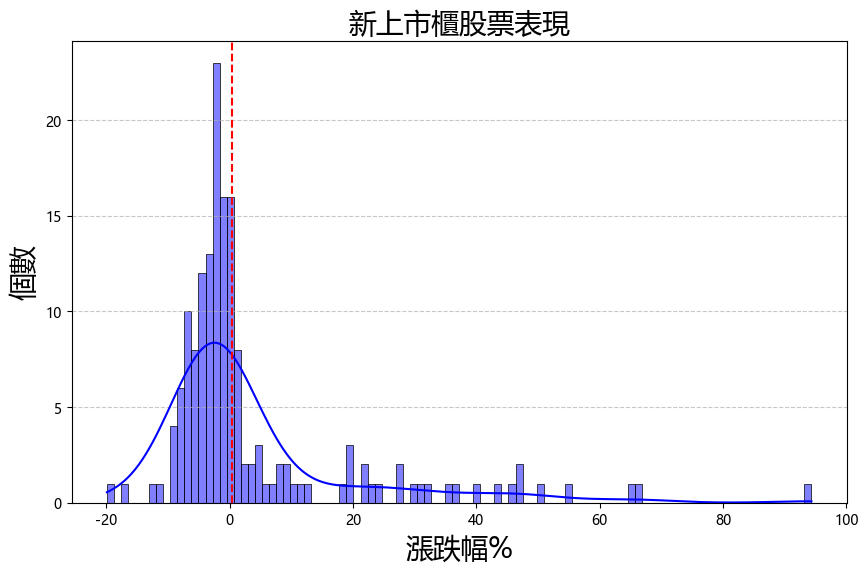

-3.9728388523792524
19.700777649428844
3.9673803469849527
勝率
54
107
0.33540372670807456
-4.958866538880742


In [87]:
import matplotlib.pyplot as plt
import seaborn as sns

# 設置中文字體
plt.rcParams['font.sans-serif'] = ['Microsoft YaHei']  # 使用微軟正黑體 (可根據系統字體選擇)
plt.rcParams['axes.unicode_minus'] = False  # 解決負號顯示問題

# 計算每日百分比變動
daylist = new_stock_list['earn2']

# 繪製直方圖
plt.figure(figsize=(10, 6))  # 設置圖形大小
sns.histplot(daylist, bins=100, kde=True, color='blue')  # 使用 Seaborn 繪製直方圖，加入 KDE 曲線
plt.title('新上市櫃股票表現', fontsize=20)  # 標題
plt.xlabel('漲跌幅%', fontsize=20)  # x 軸標籤
plt.ylabel('個數', fontsize=20)  # y 軸標籤
# 在 x=0.435 的地方畫一條垂直線
plt.axvline(x=0.435, color='red', linestyle='--', label='Price = 0.435')
plt.grid(axis='y', linestyle='--', alpha=0.7)  # 加入網格線
plt.show()


print(daylist[daylist <= 0].mean())
print(daylist[daylist > 0].mean())
print(daylist.mean())
print('勝率')

loss = len(daylist[daylist <= 0])
win = len(daylist[daylist > 0])

print(win)
print( loss)

print(win / (win + loss))
print(daylist[daylist > 0].mean() / daylist[daylist <= 0].mean())

In [89]:
p = 0.4177
b = 6.89

(p * (1+b) - 1 )/ b

0.33318621190130626

In [88]:
daylist[daylist > 0].mean() * p + (1-p) * daylist[daylist <= 0].mean()

4.594755691132249

In [85]:
import pandas as pd
# 初始化數據
data = new_stock_list[['Date','證券代號',	'證券名稱',	'sell_day',	'earn1',	'earn2']]

df = pd.DataFrame(data, columns=['Date','證券代號',	'證券名稱',	'sell_day',	'earn1',	'earn2'])

# 轉換日期格式
df['Date'] = pd.to_datetime(df['Date'])
df['sell_day'] = pd.to_datetime(df['sell_day'])

# 持倉計算
max_holding = 4
current_holding = []
holding_log = []

for index, row in df.iterrows():
    stock_id = row['證券代號']
    stock_name = row['證券名稱']
    start_date = row['Date']
    end_date = row['sell_day']
    earn = row['earn2']
    
    # 釋放已賣出的股票
    current_holding = [h for h in current_holding if h['sell_day'] >= start_date]
    
    # 如果持倉未滿，則買入
    if len(current_holding) < max_holding:
        current_holding.append({'證券代號': stock_id, '證券名稱': stock_name, 'Date': start_date, 'sell_day': end_date , 'earn2': earn})
        holding_log.append((stock_id, stock_name, start_date, end_date, earn))

# 將結果轉為 DataFrame
result = pd.DataFrame(holding_log, columns=['證券代號', '證券名稱', 'Date', 'sell_day','earn2'])
result['earn2'] = result['earn2'] / max_holding

final_profit = result['earn2'].cumsum().iloc[-1]
print(f"帳戶 {max_holding} 的最終收益: {final_profit}")

# 計算贏家與輸家的數量
win_count = len(result[result['earn2'] > 0])
loss_count = len(result[result['earn2'] <= 0])

# 計算勝率（百分比）
win_rate = (win_count / len(result)) * 100

# 計算平均獲利與平均損失
average_loss = result[result['earn2'] <= 0]['earn2'].mean() 
average_win = result[result['earn2'] > 0]['earn2'].mean() 

# 印出結果
print(f"Win Count: {win_count}")
print(f"Loss Count: {loss_count}")

print(f"勝率 (Win Rate): {win_rate:.2f}%")

print(f"Average Loss (輸家平均損失): {average_loss:.2f}%")
print(f"Average Win (贏家平均獲利): {average_win:.2f}%")


帳戶 4 的最終收益: 160.2285752116316
Win Count: 54
Loss Count: 106
勝率 (Win Rate): 33.75%
Average Loss (輸家平均損失): -1.00%
Average Win (贏家平均獲利): 4.93%


In [86]:
p = win / (win + loss)

b = daylist[daylist > 0].mean() / daylist[daylist <= 0].mean()
b = b * -1

(p*(1+b) - 1)/ b 

0.2515865442367642

In [61]:
p = 0.6557

b = 2.38

(p*(1+b) - 1)/ b 

0.5110361344537814

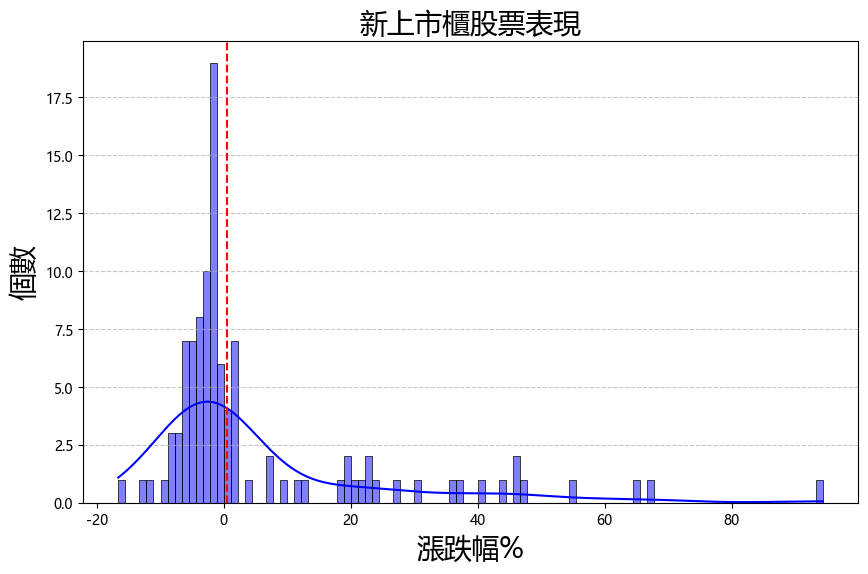

平均損失
-3.953592372797745
平均收益
22.86810392499412
平均
5.753307239736454
38
67
勝率
0.3619047619047619
賺賠比
-5.784132952687682


In [68]:
twse_df = twse_df[['Date', '指數名稱', '價格指數值','20MA', '60MA']]
twse_df['Date'] = pd.to_datetime(twse_df['Date'])
twse_df['季線上'] = twse_df['價格指數值'] > twse_df['60MA']
twse_df['月線上'] = twse_df['價格指數值'] > twse_df['20MA']
twse_df['季線下'] = twse_df['價格指數值'] <= twse_df['60MA']
twse_df['月線下'] = twse_df['價格指數值'] <= twse_df['20MA']
merged_df = pd.merge(new_stock_list, twse_df, on='Date', how='inner')

import matplotlib.pyplot as plt
import seaborn as sns

# 設置中文字體
plt.rcParams['font.sans-serif'] = ['Microsoft YaHei']  # 使用微軟正黑體 (可根據系統字體選擇)
plt.rcParams['axes.unicode_minus'] = False  # 解決負號顯示問題

# 計算每日百分比變動
daylist = merged_df[merged_df['季線上']]['earn2']

# 繪製直方圖
plt.figure(figsize=(10, 6))  # 設置圖形大小
sns.histplot(daylist, bins=100, kde=True, color='blue')  # 使用 Seaborn 繪製直方圖，加入 KDE 曲線
plt.title('新上市櫃股票表現', fontsize=20)  # 標題
plt.xlabel('漲跌幅%', fontsize=20)  # x 軸標籤
plt.ylabel('個數', fontsize=20)  # y 軸標籤
# 在 x=0.435 的地方畫一條垂直線
plt.axvline(x=0.435, color='red', linestyle='--', label='Price = 0.435')
plt.grid(axis='y', linestyle='--', alpha=0.7)  # 加入網格線
plt.show()

print('平均損失')
print(daylist[daylist <= 0].mean())
print('平均收益')
print(daylist[daylist > 0].mean())
print('平均')
print(daylist.mean())


loss = len(daylist[daylist <= 0])
win = len(daylist[daylist > 0])

print(win)
print( loss)
print('勝率')
print(win / (win + loss))
print('賺賠比')
print(daylist[daylist > 0].mean() / daylist[daylist <= 0].mean())

In [74]:
p = win / (win + loss)

b = daylist[daylist > 0].mean() / daylist[daylist <= 0].mean()
b = b * -1

(p*(1+b) - 1)/ b 

0.2515865442367642

In [75]:
b

5.784132952687682

In [76]:
daylist[daylist > 0].mean() * p + (1-p) * daylist[daylist <= 0].mean()

5.753307239736453

In [77]:
daylist

0      46.525680
1      55.426357
2      -1.914894
3      -4.000000
4      -2.786885
         ...    
156    -6.358974
157    -4.031008
158    -6.106870
159    -6.578947
160    -3.171642
Name: earn2, Length: 105, dtype: float64

In [32]:
# new_stock_list[(new_stock_list['Date'] > '2022-04-01') & (new_stock_list['Date'] < '2022-10-31')]
print(merged_df[merged_df['季線上']]['earn2'].mean())
print(merged_df[merged_df['月線上']]['earn2'].mean())
print(merged_df[merged_df['季線下']]['earn2'].mean())
print(merged_df[merged_df['月線下']]['earn2'].mean())
print(merged_df['earn2'].mean())

5.753307239736454
5.622991970268788
0.6187674230758888
0.6868165749225396
3.9673803469849527


In [81]:
import pandas as pd
new_stock_list2 = merged_df[merged_df['季線上']].sort_values(by='Date')

# 初始化數據
data = new_stock_list2[['Date','證券代號',	'證券名稱',	'sell_day',	'earn1',	'earn2']]

df = pd.DataFrame(data, columns=['Date','證券代號',	'證券名稱',	'sell_day',	'earn1',	'earn2'])

# 轉換日期格式
df['Date'] = pd.to_datetime(df['Date'])
df['sell_day'] = pd.to_datetime(df['sell_day'])

# 持倉計算
max_holding = 4
current_holding = []
holding_log = []

for index, row in df.iterrows():
    stock_id = row['證券代號']
    stock_name = row['證券名稱']
    start_date = row['Date']
    end_date = row['sell_day']
    earn = row['earn2']
    
    # 釋放已賣出的股票
    current_holding = [h for h in current_holding if h['sell_day'] >= start_date]
    
    # 如果持倉未滿，則買入
    if len(current_holding) < max_holding:
        current_holding.append({'證券代號': stock_id, '證券名稱': stock_name, 'Date': start_date, 'sell_day': end_date , 'earn2': earn})
        holding_log.append((stock_id, stock_name, start_date, end_date, earn))

# 將結果轉為 DataFrame
result = pd.DataFrame(holding_log, columns=['證券代號', '證券名稱', 'Date', 'sell_day','earn2'])
result['earn2'] = result['earn2'] / max_holding

final_profit = result['earn2'].cumsum().iloc[-1]
print(f"帳戶 {max_holding} 的最終收益: {final_profit}")

# 計算贏家與輸家的數量
win_count = len(result[result['earn2'] > 0])
loss_count = len(result[result['earn2'] <= 0])

# 計算勝率（百分比）
win_rate = (win_count / len(result)) * 100

# 計算平均獲利與平均損失
average_loss = result[result['earn2'] <= 0]['earn2'].mean() 
average_win = result[result['earn2'] > 0]['earn2'].mean() 

# 印出結果
print(f"Win Count: {win_count}")
print(f"Loss Count: {loss_count}")

print(f"勝率 (Win Rate): {win_rate:.2f}%")

print(f"Average Loss (輸家平均損失): {average_loss:.2f}%")
print(f"Average Win (贏家平均獲利): {average_win:.2f}%")


帳戶 4 的最終收益: 151.56583128856926
Win Count: 38
Loss Count: 66
勝率 (Win Rate): 36.54%
Average Loss (輸家平均損失): -1.00%
Average Win (贏家平均獲利): 5.72%


In [38]:
# pd.DataFrame(holding_log, columns=['證券代號', '證券名稱', 'Date', 'sell_day','earn2'])

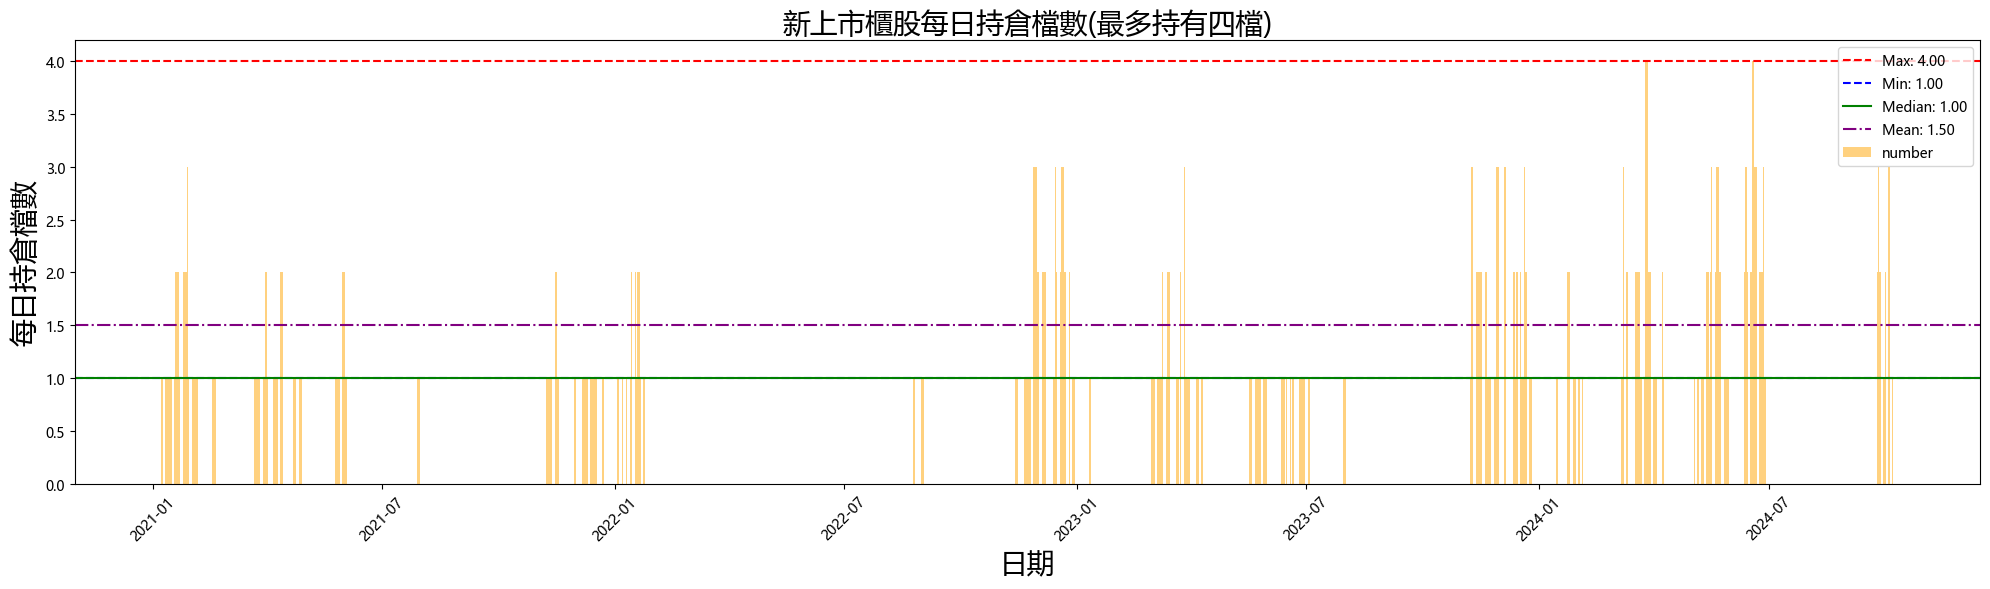

In [82]:
import matplotlib.pyplot as plt
everyday_list = pd.DataFrame(columns=['hold_day','stock_id'])
stock_2330 = stock_df_raw[stock_df_raw['證券代號'] == '2330']
Date_list = stock_2330[(stock_2330['Date'] >= '2021-01-01') & (stock_2330['Date'] <= '2024-10-30')]['Date']

for i in range(len(result)):
    stock_info = result.iloc[i]
    buy_date = stock_info['Date']
    sell_date = stock_info['sell_day']

    stock_id = stock_info['證券代號']
    
    Date_list = stock_2330[(stock_2330['Date'] >= buy_date) & (stock_2330['Date'] <= sell_date)]['Date']

    for day in Date_list:
        temp_df = pd.DataFrame({
            'hold_day': [day],
            'stock_id' : [stock_id],
        })

        # 删除全为NA的列，避免可能出现的警告
        temp_df.dropna(axis=1, how='all', inplace=True)
        if not temp_df.empty:
            everyday_list = pd.concat([everyday_list, temp_df], ignore_index=True)


everyday_list = everyday_list.groupby('hold_day').size()
everyday_list.columns = ['buy_date', 'size']
everyday_list = everyday_list.to_frame(name='size')

# Set the figure size
plt.figure(figsize=(20, 6))

plt.bar(everyday_list.index, everyday_list['size'], width=1, label='number', alpha=0.5, color='orange')

# Add horizontal lines for max, min, mean, and median of everyday_list
plt.axhline(everyday_list['size'].max(), color='red', linestyle='--', label=f'Max: {everyday_list["size"].max():.2f}')
plt.axhline(everyday_list['size'].min(), color='blue', linestyle='--', label=f'Min: {everyday_list["size"].min():.2f}')
plt.axhline(everyday_list['size'].median(), color='green', linestyle='-', label=f'Median: {everyday_list["size"].median():.2f}')
plt.axhline(everyday_list['size'].mean(), color='purple', linestyle='-.', label=f'Mean: {everyday_list["size"].mean():.2f}')

# Add titles and labels
plt.title('新上市櫃股每日持倉檔數(最多持有四檔)', fontsize=20)
plt.xlabel('日期', fontsize=20)
plt.ylabel('每日持倉檔數', fontsize=20)

# Rotate the x-axis labels for better readability
plt.xticks(rotation=45)

# Add a legend
plt.legend(loc='upper right')

# Show the plot
plt.tight_layout()
plt.show()


In [83]:
# result[result['迄日'] > '2020-12-01']
Date_list = stock_2330[(stock_2330['Date'] >= '2021-01-01') & (stock_2330['Date'] <= '2024-10-31')]['Date']
print(len(everyday_list))
print(len(Date_list))
print(len(everyday_list)/len(Date_list))

261
928
0.28125


In [74]:
# earn_price_list[earn_price_list['earn_price'] > 0]

Start date,2021-01-04
End date,2024-10-30
Total months,44
,Backtest
Annual return,46.282%
Cumulative returns,305.809%
Annual volatility,25.974%
Sharpe ratio,1.58
Calmar ratio,5.39
Stability,0.91
Max drawdown,-8.594%


Worst drawdown periods,Net drawdown in %,Peak date,Valley date,Recovery date,Duration
0,8.59,2023-12-25,2024-03-21,2024-05-30,114
1,6.41,2024-09-25,2024-10-07,NaT,NaN
2,6.16,2021-04-12,2021-06-01,2021-11-17,158
3,5.34,2023-03-10,2023-03-27,2023-04-10,22
4,4.88,2021-12-22,2022-01-17,2022-01-24,24


C:\Users\USER\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.12_qbz5n2kfra8p0\LocalCache\local-packages\Python312\site-packages\pyfolio\plotting.py:1407: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(["Daily", "Weekly", "Monthly"])


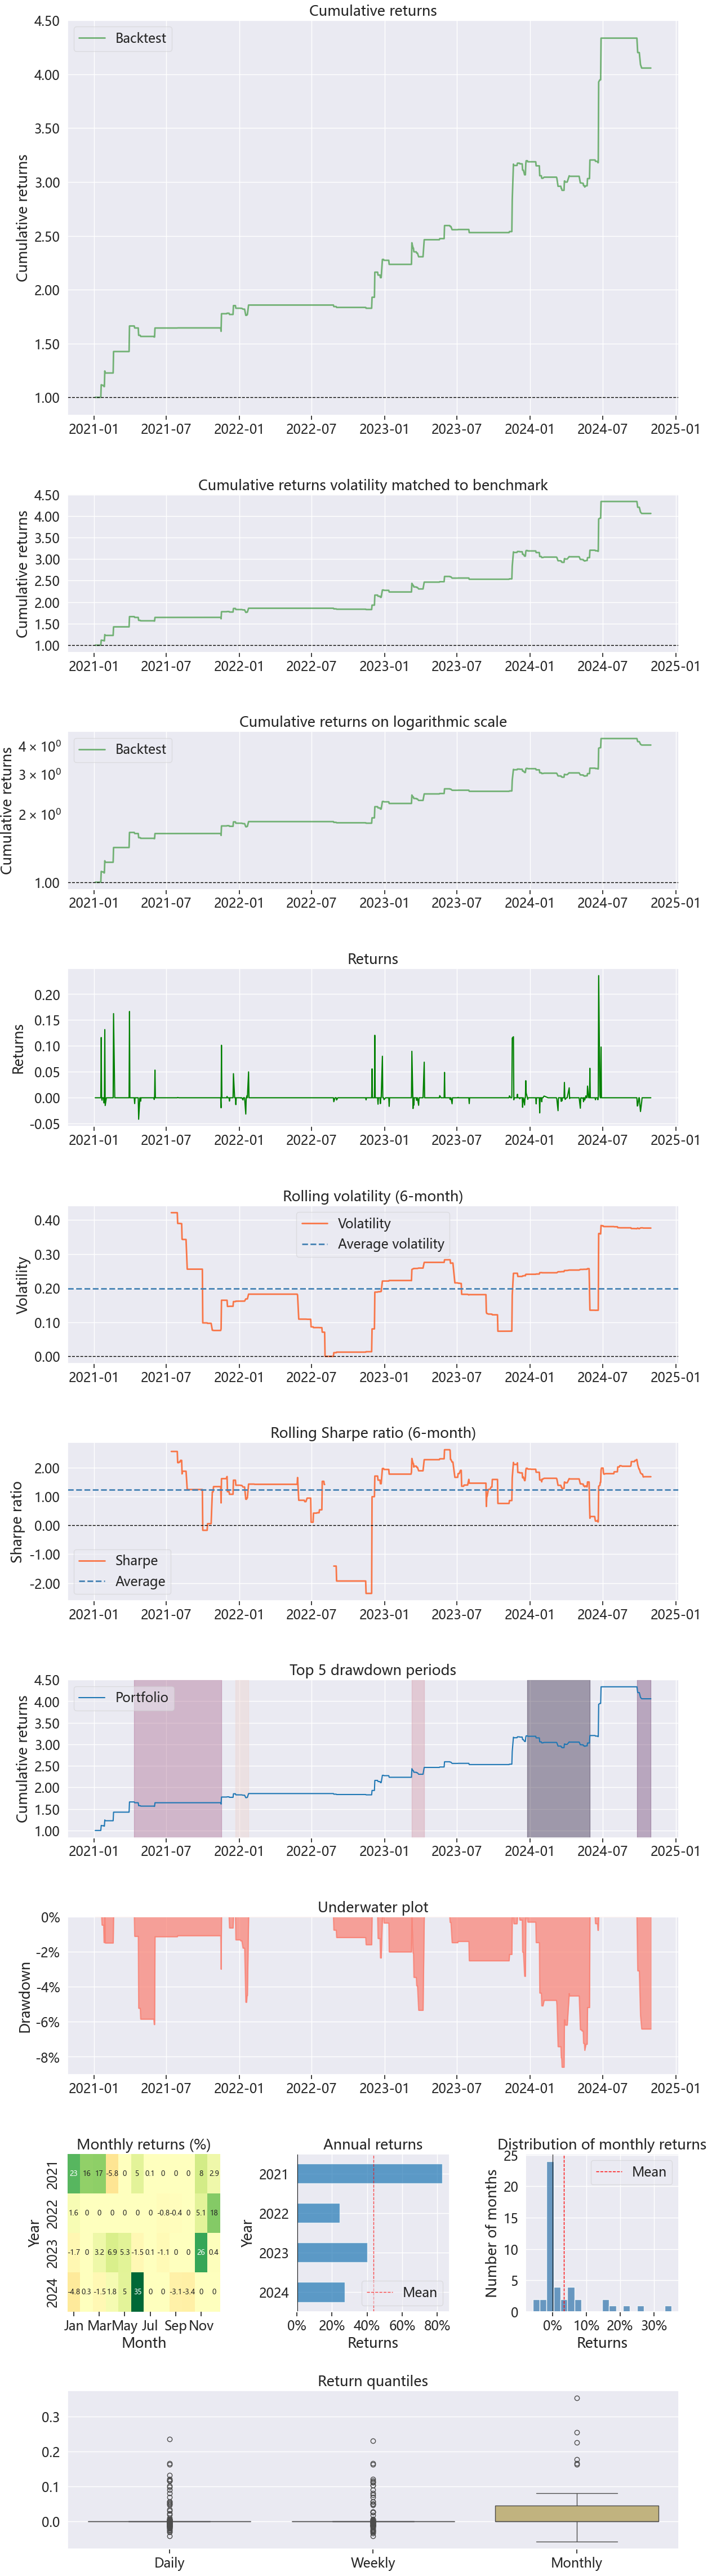

In [84]:
# 篩選日期範圍
Date_list = stock_2330.query("'2021-01-01' <= Date <= '2024-10-31'")['Date']

# 計算每個日期的收益，補全其他日期為 0
earn_price_list = (
    result[result['sell_day'].isin(Date_list)]
    .groupby('sell_day')['earn2']
    .sum()
    .reindex(Date_list, fill_value=0)  # 補零
    .reset_index()
    .rename(columns={'sell_day': 'Date', 'earn2': 'earn_price'})
)

# 將收益轉換為百分比
earn_price_list['earn_price'] /= 100

# 使用 pyfolio 分析收益
import pyfolio as pf
pf.create_returns_tear_sheet(earn_price_list.set_index('Date')['earn_price'])


In [19]:
# print(new_stock_list[new_stock_list['loss_type'] == '4']['earn1'].mean())
# print(len(new_stock_list[new_stock_list['loss_type'] == '4']))
# print(new_stock_list[new_stock_list['loss_type'] == '4']['earn2'].mean())

# print(new_stock_list[new_stock_list['loss_type'] == '1']['earn1'].mean())
# print(len(new_stock_list[new_stock_list['loss_type'] == '1']))
# print(new_stock_list[new_stock_list['loss_type'] == '1']['earn2'].mean())



不停損只看EARN1

In [47]:
# 先找上市第一筆
import numpy as np
import warnings
# 忽略 FutureWarning
warnings.simplefilter(action='ignore', category=FutureWarning)

stock_df_raw['Date'] = pd.to_datetime(stock_df_raw['Date'])
new_stock_df = stock_df_raw[(stock_df_raw['Date'] > '2020-06-10') & (stock_df_raw['5MA'] == 0) & (stock_df_raw['10MA'] == 0) & (stock_df_raw['20MA'] == 0) & (stock_df_raw['60MA'] == 0) ]

new_stock_id = new_stock_df['證券代號'].unique().tolist()

total_earn = 0


cumsum_list = pd.DataFrame(columns=['loss_pen','cumsum1','cumsum2','len','edge_ratio','hold_day'])
loss_pen = 1.00
hold_day = 7 # 7
loss_pen_list = np.arange(11, 13, 1)
earn1 = 0
earn2 = 0



for hold_day in loss_pen_list: 
    new_stock_list = pd.DataFrame(columns=['Date','證券代號','證券名稱',
                                           'Day1開盤價','Day1最低價','Day1最高價','Day1收盤價','Day1一半','day1_high_pen','day1_low_pen',
                                           'Day2開盤價','Day2收盤價','Day3開盤價','Day3收盤價','Day8開盤價','Day8收盤價','Day1Diff',
                                           '最後賣出價','sell_day','day1_volume','Day85MA','earn1','earn2',
                                           'lossDay_price','lossDay_Date','loss_type',
                                           'GMFE','MAE','BMFE'])
    
    for stock_id in new_stock_id:
        
        new_stock = stock_df_raw[stock_df_raw['證券代號'] == stock_id]
        new_stock = new_stock.head(hold_day+1)

        # MAE之前發生的最大有利方向幅度
        BMFE = 0
        # 全域最大有利方向幅度
        GMFE = 0
        # 最大不利方向幅度
        MAE = 0

        if (len(new_stock) == hold_day+1):
            lossDay_price = 0
            lossDay_Date = ''
            loss_type = '0'
            day1_open_price = new_stock['開盤價'].iloc[0]
            day1_low_price = new_stock['最低價'].iloc[0]
            day1_high_price = new_stock['最高價'].iloc[0]
            day1_close_price = new_stock['收盤價'].iloc[0]
            day1_volume = new_stock['成交筆數'].iloc[0]

            # 最低價與開盤價差別
            day1_low_pen = day1_low_price/day1_open_price
            # 最高價與開盤價差別
            day1_high_pen = day1_high_price/day1_open_price


            day1_diff = day1_close_price - day1_open_price

            day1_half_price = round((day1_open_price + day1_close_price) / 2 , 2)

            Date = new_stock['Date'].iloc[0]
            id = new_stock['證券代號'].iloc[0]
            name = new_stock['證券名稱'].iloc[0]

            close_price = new_stock['收盤價'].iloc[hold_day] # 第八天
            close_date = new_stock['Date'].iloc[hold_day] # 第八天
            MA5 = new_stock['5MA'].iloc[hold_day] 

            # 第二天開盤收盤價
            day2_open_price = new_stock['開盤價'].iloc[1]
            day2_close_price = new_stock['收盤價'].iloc[1]
            
            # 第三天開盤收盤價
            day3_open_price = new_stock['開盤價'].iloc[2]
            day3_close_price = new_stock['收盤價'].iloc[2]


            # 第八天開盤收盤價
            # day8_open_price = new_stock['開盤價'].iloc[7]
            # day8_close_price = new_stock['收盤價'].iloc[7]
            day8_open_price = 0
            day8_close_price = 0

            #第一天買不到就算了 再追效果不好
            if((day1_open_price == day1_low_price) & (day1_low_price == day1_close_price)):
                continue

            # 1. 直接放hold_day天 中間不動作 開盤買
            earn1 = 100 * (close_price - day1_open_price)/day1_open_price

            hold8_data = new_stock[new_stock['Date'] <= close_date]
            # MAE只有負數 如果都沒跌破開盤價 MAE 就是0
            if(hold8_data['收盤價'].min() > day1_open_price ) :
                MAE = 0
            else:
                MAE  = 100 * (hold8_data['收盤價'].min() - day1_open_price)/day1_open_price

            sell_day = new_stock.iloc[hold_day]['Date'] # 第八天

            result_df = pd.DataFrame({
                'Date': [Date],
                '證券代號': [id],
                '證券名稱': [name],
                'Day1開盤價': [day1_open_price],
                'Day1最低價': [day1_low_price],
                'Day1最高價': [day1_high_price],
                'Day1收盤價': [day1_close_price],
                'Day1一半': [day1_half_price],
                'day1_high_pen': [day1_high_pen],
                'day1_low_pen': [day1_low_pen],
                'Day2開盤價' : [day2_open_price],
                'Day2收盤價' : [day2_close_price],
                'Day3開盤價' : [day3_open_price],
                'Day3收盤價' : [day3_close_price],
                'Day8開盤價' : [day8_open_price],
                'Day8收盤價' : [day8_close_price],
                'Day1Diff' :[day1_diff],
                '最後賣出價' : [close_price],
                'sell_day' : [sell_day],
                'day1_volume' : [day1_volume],
                'Day85MA': [MA5],
                'earn1': [earn1],
                'earn2': [earn2],
                'lossDay_price':[lossDay_price],
                'lossDay_Date':[lossDay_Date],
                'loss_type':[loss_type],
                'GMFE':[GMFE],
                'MAE':[MAE],
                'BMFE':[BMFE]
            })

            # 删除全为NA的列，避免可能出现的警告
            result_df.dropna(axis=1, how='all', inplace=True)
            if not result_df.empty:
                new_stock_list = pd.concat([new_stock_list, result_df], ignore_index=True)

    new_stock_list['cumsum1'] = new_stock_list['earn1'].cumsum()
    new_stock_list['cumsum2'] = new_stock_list['earn2'].cumsum()
    edge_ratio = new_stock_list['GMFE'].mean() / abs(new_stock_list['MAE'].mean())
    temp_df = pd.DataFrame({
        'loss_pen': [loss_pen],
        'cumsum1': [new_stock_list['cumsum1'].iloc[-1]],
        'cumsum2': [new_stock_list['cumsum2'].iloc[-1]],
        'len' : [len(new_stock_list)],
        'edge_ratio': [edge_ratio],
        'hold_day':[hold_day]
    })
    if not temp_df.empty:
        cumsum_list = pd.concat([cumsum_list, temp_df], ignore_index=True)

cumsum_list


,loss_pen,cumsum1,cumsum2,len,edge_ratio,hold_day
0,1.0,552.828319,0,159,0.0,11
1,1.0,616.540745,0,159,0.0,12


In [39]:
count_hold_day_list = new_stock_list[['Date','sell_day']]
stock_2330 = stock_df_raw[stock_df_raw['證券代號'] == '2330']
hold_day_count = 0
for i in range(len(count_hold_day_list)):
    row = count_hold_day_list.iloc[i]
    select_day = row['Date']
    sell_day = row['sell_day']
    hold_day_count += len(stock_2330[(stock_2330['Date'] >= select_day) & (stock_2330['Date'] < sell_day) ])

hold_day_count / len(count_hold_day_list)  


2.6149068322981366

In [40]:
stock_2330 = stock_df_raw[stock_df_raw['證券代號'] == '2330']

new_stock_list[['Date','sell_day']]

earn_date_list = pd.DataFrame(columns=['hold_day','stock_id','stock_name'])

for i in range(len(new_stock_list)):
    stock_info = new_stock_list.iloc[i]
    buy_day = stock_info['Date']
    sell_day = stock_info['sell_day']

    stock_id = stock_info['證券代號']
    stock_name = stock_info['證券名稱']
    
    Date_list = stock_2330[(stock_2330['Date'] >= buy_day) & (stock_2330['Date'] < sell_day)]['Date']

    for day in Date_list:
        temp_df = pd.DataFrame({
            'hold_day': [day],
            'stock_id' : [stock_id],
            'stock_name' : [stock_name]
        })

        temp_df.dropna(axis=1, how='all', inplace=True)
        if not temp_df.empty:
            earn_date_list = pd.concat([earn_date_list, temp_df], ignore_index=True)

earn_date_list2 = earn_date_list.groupby('hold_day').size()
earn_date_list2.columns = ['hold_day', 'size']
earn_date_list2 = earn_date_list2.to_frame(name='size')

In [36]:
print(len(earn_date_list2))
print(len(stock_2330[(stock_2330['Date'] >= '2021-01-08') & (stock_2330['Date'] <= '2024-10-09')]['Date']))
len(earn_date_list2) / len(stock_2330[(stock_2330['Date'] >= '2021-01-08') & (stock_2330['Date'] <= '2024-10-09')]['Date'])


313
910


0.34395604395604396

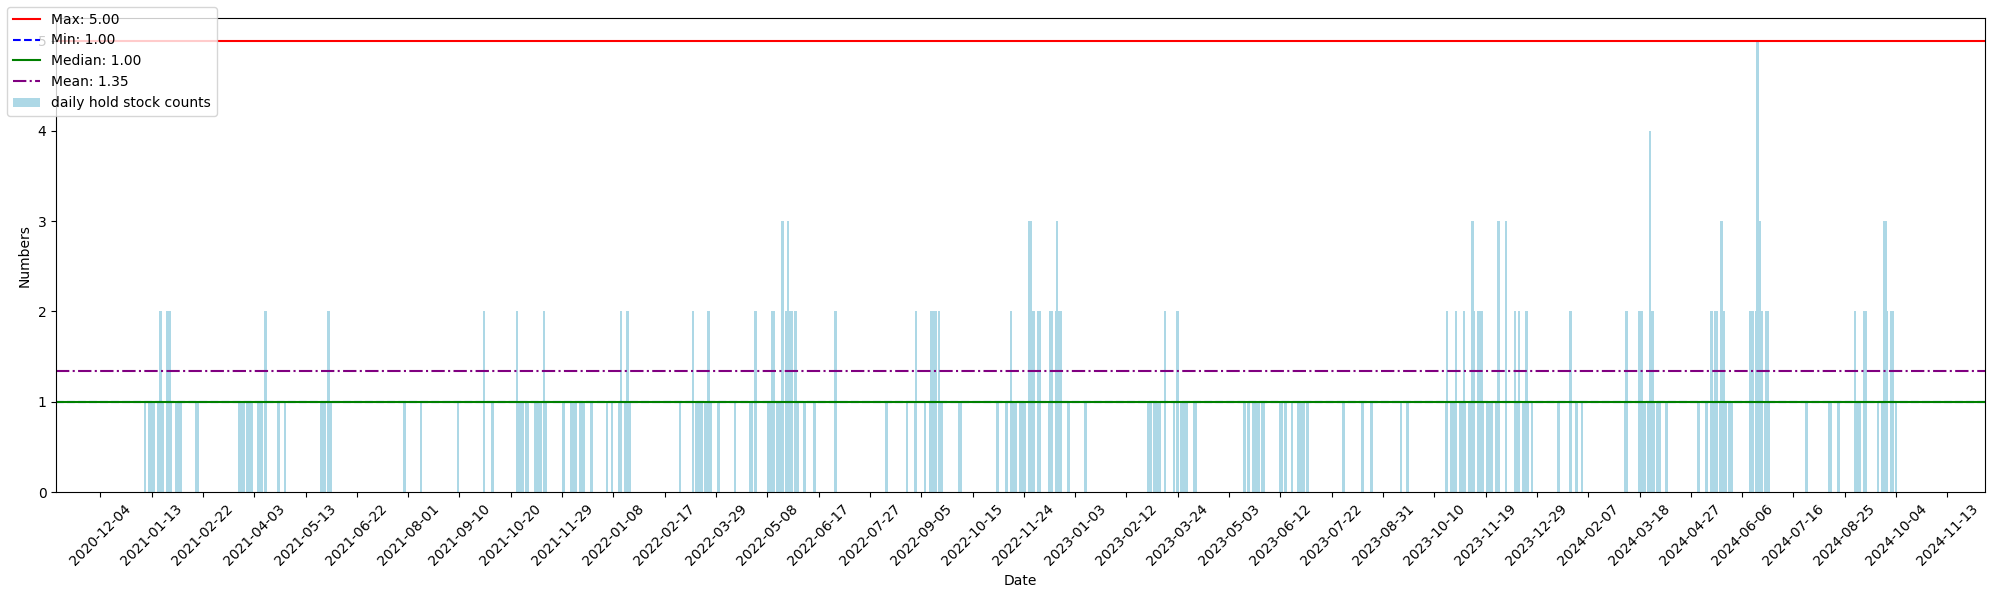

In [41]:
import matplotlib.pyplot as plt
from matplotlib.ticker import MaxNLocator
import matplotlib.dates as mdates

# Set the figure size
fig, ax1 = plt.subplots(figsize=(20, 6))

# Plot the bar chart with dates on the x-axis and 'size' values on the primary y-axis
ax1.bar(earn_date_list2.index, earn_date_list2['size'], width=2, color='lightblue', label='daily hold stock counts')


# Add horizontal lines for max, min, mean, and median
ax1.axhline(earn_date_list2['size'].max(), color='red', linestyle='-', label=f'Max: {earn_date_list2['size'].max():.2f}')
ax1.axhline(earn_date_list2['size'].min(), color='blue', linestyle='--', label=f'Min: {earn_date_list2['size'].min():.2f}')
ax1.axhline(earn_date_list2['size'].median(), color='green', linestyle='-', label=f'Median: {earn_date_list2['size'].median():.2f}')
ax1.axhline(earn_date_list2['size'].mean(), color='purple', linestyle='-.', label=f'Mean: {earn_date_list2['size'].mean():.2f}')

# 設定 x 軸只顯示日期
ax1.xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m-%d'))  # 格式化日期顯示
ax1.xaxis.set_major_locator(mdates.AutoDateLocator())  # 自動設置日期間隔
ax1.xaxis.set_major_locator(MaxNLocator(prune=None, nbins=50))  # 增加 Y 軸標籤數量

ax1.set_xlabel('Date')
ax1.set_ylabel('Numbers')

# Rotate the x-axis labels for better readability
ax1.tick_params(axis='x', rotation=45)
# Add legends for both plots
fig.legend(loc="upper left", bbox_transform=ax1.transAxes)
# Show the plot
fig.tight_layout()
# Show the plot
plt.show()


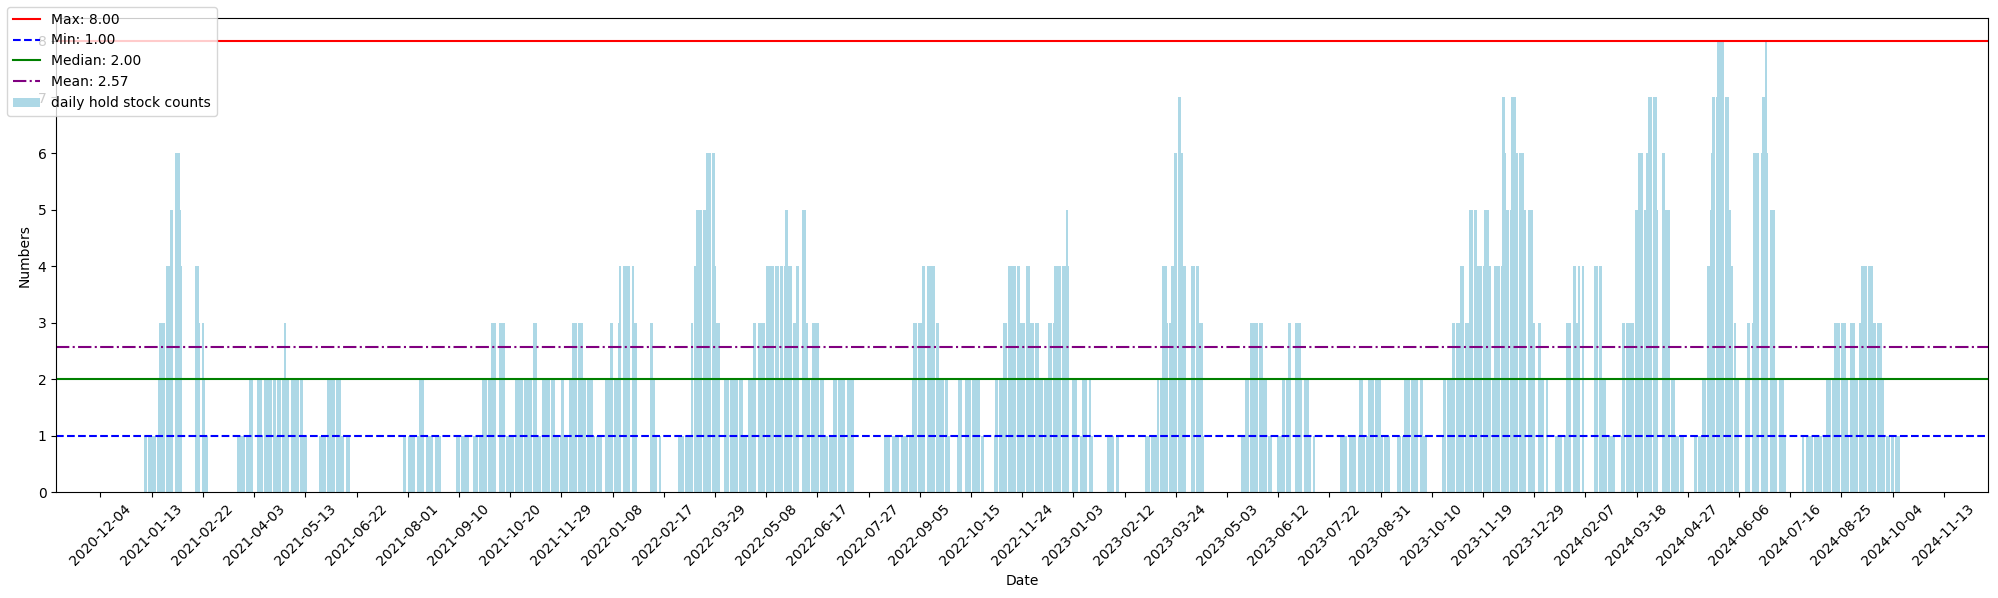

In [36]:
import matplotlib.pyplot as plt
from matplotlib.ticker import MaxNLocator
import matplotlib.dates as mdates

# Set the figure size
fig, ax1 = plt.subplots(figsize=(20, 6))

# Plot the bar chart with dates on the x-axis and 'size' values on the primary y-axis
ax1.bar(earn_date_list2.index, earn_date_list2['size'], width=2, color='lightblue', label='daily hold stock counts')


# Add horizontal lines for max, min, mean, and median
ax1.axhline(earn_date_list2['size'].max(), color='red', linestyle='-', label=f'Max: {earn_date_list2['size'].max():.2f}')
ax1.axhline(earn_date_list2['size'].min(), color='blue', linestyle='--', label=f'Min: {earn_date_list2['size'].min():.2f}')
ax1.axhline(earn_date_list2['size'].median(), color='green', linestyle='-', label=f'Median: {earn_date_list2['size'].median():.2f}')
ax1.axhline(earn_date_list2['size'].mean(), color='purple', linestyle='-.', label=f'Mean: {earn_date_list2['size'].mean():.2f}')

# 設定 x 軸只顯示日期
ax1.xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m-%d'))  # 格式化日期顯示
ax1.xaxis.set_major_locator(mdates.AutoDateLocator())  # 自動設置日期間隔
ax1.xaxis.set_major_locator(MaxNLocator(prune=None, nbins=50))  # 增加 Y 軸標籤數量

ax1.set_xlabel('Date')
ax1.set_ylabel('Numbers')

# Rotate the x-axis labels for better readability
ax1.tick_params(axis='x', rotation=45)
# Add legends for both plots
fig.legend(loc="upper left", bbox_transform=ax1.transAxes)
# Show the plot
fig.tight_layout()
# Show the plot
plt.show()


In [5]:
new_stock_list['抱1天損益'] = round(100 * (new_stock_list['Day1收盤價'] - new_stock_list['Day1開盤價']) / new_stock_list['Day1開盤價'] , 2)
new_stock_list['抱2天損益'] = round(100 * (new_stock_list['Day2收盤價'] - new_stock_list['Day1開盤價']) / new_stock_list['Day1開盤價'] , 2)
new_stock_list['抱3天損益'] = round(100 * (new_stock_list['Day3收盤價'] - new_stock_list['Day1開盤價']) / new_stock_list['Day1開盤價'] , 2)
new_stock_list['抱8天損益'] = round(100 * (new_stock_list['Day8收盤價'] - new_stock_list['Day1開盤價']) / new_stock_list['Day1開盤價'] , 2)


new_stock_list_simple = new_stock_list[['Date','證券代號','證券名稱','day1_volume','Day1開盤價','Day1收盤價','Day2開盤價','Day2收盤價','Day3開盤價','Day3收盤價','Day8開盤價','Day8收盤價','抱1天損益','抱2天損益','抱3天損益','抱8天損益']]

new_stock_list_simple


,Date,證券代號,證券名稱,day1_volume,Day1開盤價,Day1收盤價,Day2開盤價,Day2收盤價,Day3開盤價,Day3收盤價,Day8開盤價,Day8收盤價,抱1天損益,抱2天損益,抱3天損益,抱8天損益
0,2021-01-08,6712,長聖,1953,165.5,172.50,175.0,177.00,175.50,174.0,242.5,242.50,4.23,6.95,5.14,46.53
1,2021-01-19,6747,亨泰光,743,129.0,139.50,138.0,161.00,159.00,162.0,200.0,200.50,8.14,24.81,25.58,55.43
2,2021-01-20,6515,穎崴,1941,470.0,486.00,492.0,461.00,454.50,459.5,449.0,417.50,3.40,-1.91,-2.23,-11.17
3,2021-01-25,6767,台微醫,810,37.5,36.90,36.0,35.10,35.00,34.8,31.9,32.45,-1.60,-6.40,-7.20,-13.47
4,2021-01-27,6661,威健生技,793,30.5,31.15,31.0,29.65,30.05,28.1,27.3,27.05,2.13,-2.79,-7.87,-11.31
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
154,2024-09-10,2751,王座,576,80.9,74.50,75.0,71.10,71.50,71.9,71.3,71.00,-7.91,-12.11,-11.12,-12.24
155,2024-09-20,4772,台特化,6654,180.0,197.00,197.0,192.00,192.00,183.5,189.0,180.00,9.44,6.67,1.94,0.00
156,2024-09-25,6923,中台,1857,97.5,91.30,91.3,89.40,89.90,89.9,89.9,89.50,-6.36,-8.31,-7.79,-8.21
157,2024-09-25,6967,汎瑋材料,1315,64.5,70.00,70.0,79.90,76.50,73.0,61.5,60.70,8.53,23.88,13.18,-5.89


In [24]:
file_path = 'c:/Users/USER/OneDrive/桌面/佛爾德/stock/new_stock_list_simple.xlsx'
new_stock_list_simple.to_excel(file_path, index=False)

In [22]:
print(new_stock_list_simple['抱1天損益'].sum() / len(new_stock_list_simple))
print(new_stock_list_simple['抱2天損益'].sum() / len(new_stock_list_simple))
print(new_stock_list_simple['抱3天損益'].sum() / len(new_stock_list_simple))
print(new_stock_list_simple['抱8天損益'].sum() / len(new_stock_list_simple))

print('=========================================')

print(new_stock_list[new_stock_list['抱1天損益']<0]['抱1天損益'].sum() / len(new_stock_list[new_stock_list['抱1天損益']<0]))
print(new_stock_list[new_stock_list['抱1天損益']<0]['抱2天損益'].sum() / len(new_stock_list[new_stock_list['抱1天損益']<0]))
print(new_stock_list[new_stock_list['抱1天損益']<0]['抱3天損益'].sum() / len(new_stock_list[new_stock_list['抱1天損益']<0]))
print(new_stock_list[new_stock_list['抱1天損益']<0]['抱8天損益'].sum() / len(new_stock_list[new_stock_list['抱1天損益']<0]))

print('=========================================')

print(new_stock_list[new_stock_list['抱1天損益']>0]['抱1天損益'].sum() / len(new_stock_list[new_stock_list['抱1天損益']>0]))
print(new_stock_list[new_stock_list['抱1天損益']>0]['抱2天損益'].sum() / len(new_stock_list[new_stock_list['抱1天損益']>0]))
print(new_stock_list[new_stock_list['抱1天損益']>0]['抱3天損益'].sum() / len(new_stock_list[new_stock_list['抱1天損益']>0]))
print(new_stock_list[new_stock_list['抱1天損益']>0]['抱8天損益'].sum() / len(new_stock_list[new_stock_list['抱1天損益']>0]))


2.4940880503144656
1.9967924528301888
1.6526415094339622
2.908238993710692
-4.154307692307693
-5.419846153846154
-6.249076923076924
-6.680461538461538
7.325164835164835
7.345604395604395
7.302637362637363
9.543076923076924


In [18]:
import pyfolio as pf
new_stock_list['Date'] = pd.to_datetime(new_stock_list['Date'])
stock_pf = new_stock_list.copy()

stock_pf_first = stock_pf.drop_duplicates(subset='Date', keep='first')
stock_pf_first.set_index(['Date'], inplace=True)

# 製造假的Date

# earn_date_list = pd.DataFrame(columns=['Date','earn2'])
# for i in range(len(stock_pf)):
#     earn2 = stock_pf['earn2'].iloc[i]
#     Date = stock_df_raw[stock_df_raw['證券代號'] == '2330']['Date'].iloc[i]

#     result_df = pd.DataFrame({
#         'Date': [Date],
#         'earn2': [earn2]
#     })

#     # 删除全为NA的列，避免可能出现的警告
#     result_df.dropna(axis=1, how='all', inplace=True)
#     if not result_df.empty:
#         earn_date_list = pd.concat([earn_date_list, result_df], ignore_index=True)

# earn_date_list.set_index(['Date'], inplace=True)

解釋可以看這個
https://www.aicoin.com/zh-Hant/article/112540

Start date,2021-07-29
End date,2024-09-20
Total months,5
,Backtest
Annual return,7399.708%
Cumulative returns,617.257%
Annual volatility,235.44%
Sharpe ratio,2.76
Calmar ratio,180.39
Stability,0.91
Max drawdown,-41.02%


Worst drawdown periods,Net drawdown in %,Peak date,Valley date,Recovery date,Duration
0,41.02,2023-11-21,2024-03-08,2024-06-12,147
1,36.44,2024-06-13,2024-09-10,NaT,NaN
2,26.42,2023-05-22,2023-10-20,2023-11-08,123
3,24.17,2022-01-13,2022-05-09,2022-05-20,92
4,23.66,2021-07-29,2021-10-25,2021-11-08,73


C:\Users\USER\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.12_qbz5n2kfra8p0\LocalCache\local-packages\Python312\site-packages\pyfolio\plotting.py:1407: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(["Daily", "Weekly", "Monthly"])


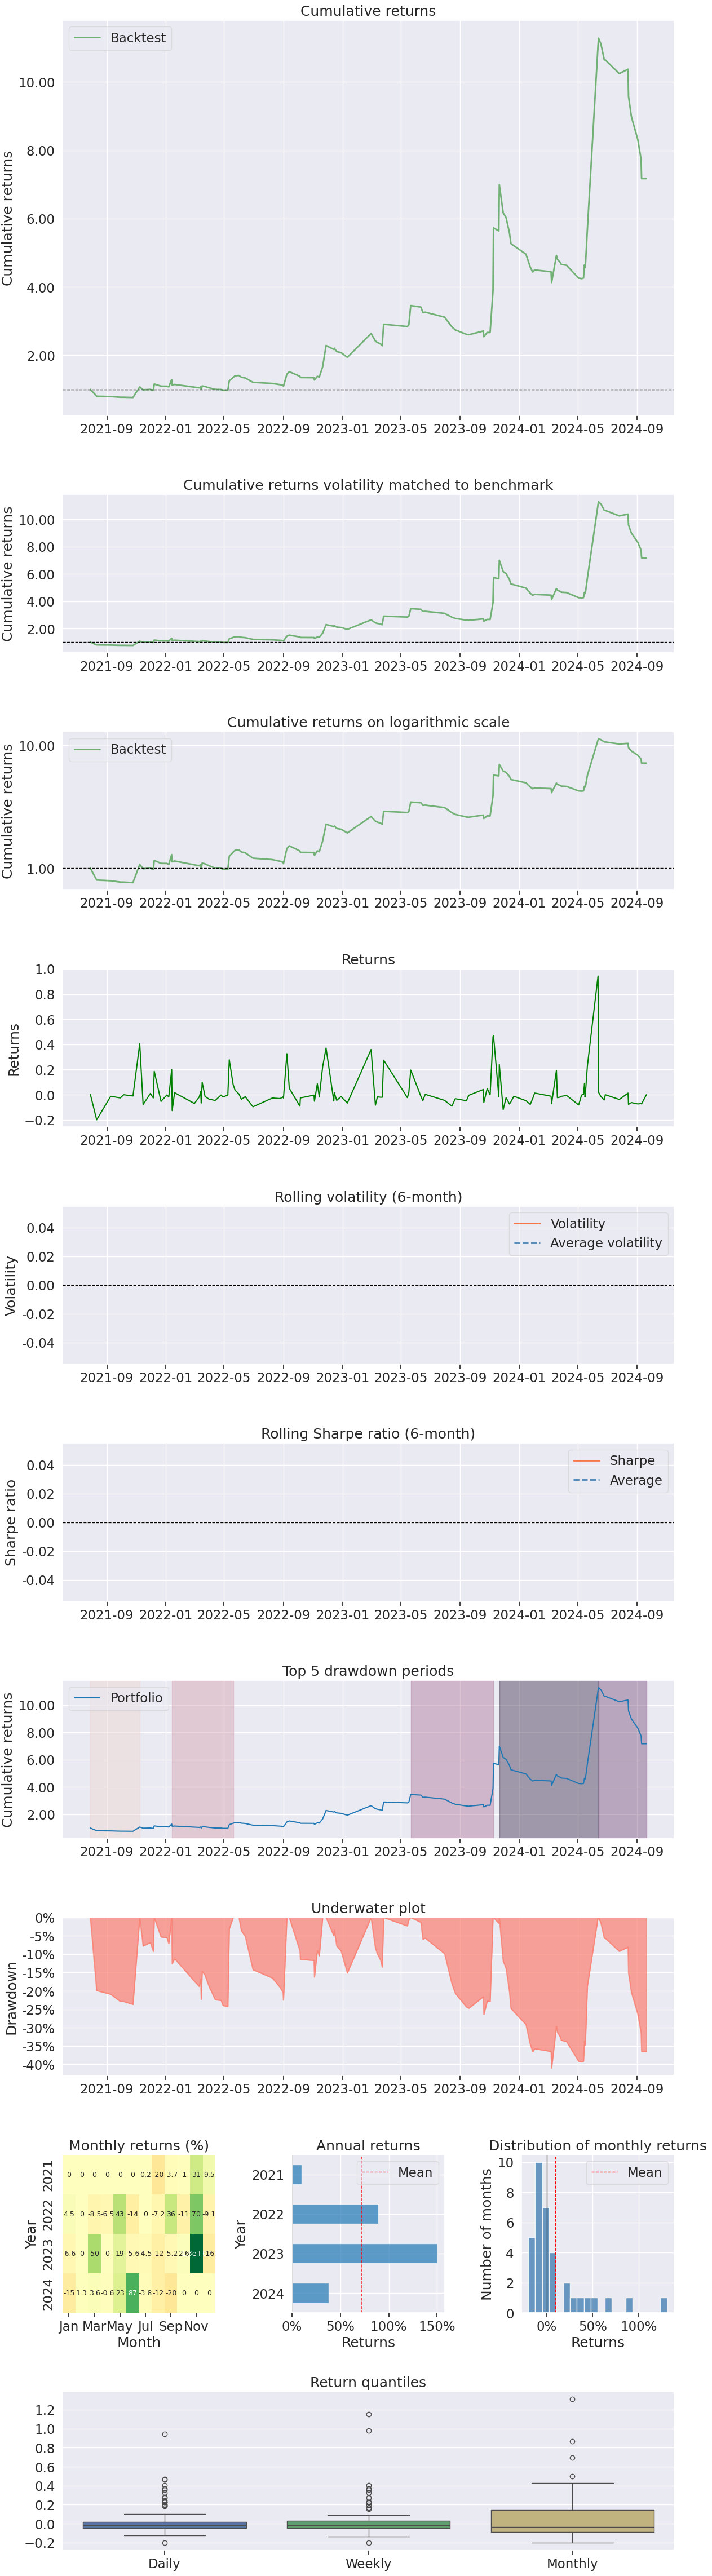

In [19]:
# stock_pf_first = stock_pf.drop_duplicates(subset='Date', keep='first')
# stock_pf_first.set_index(['Date'], inplace=True)
# pf.create_returns_tear_sheet(stock_pf_first['earn2'])
# stock_pf['earn2'].cumsum().plot()

import pyfolio as pf
pf.create_returns_tear_sheet(stock_pf_first['earn2']/100)

In [4]:
df = pd.read_csv('c:/Users/USER/OneDrive/桌面/佛爾德/price.csv',index_col=['stock_id', 'date'], parse_dates=['date'])
df2330 = df.loc['2330']
df2330 = df2330.apply(pd.to_numeric, errors='coerce')

In [9]:
df2330 = df2330.tail(100)

In [11]:
import pyfolio as pf
# pf.create_returns_tear_sheet( (df2330['收盤價']- df2330['開盤價']) /  df2330['開盤價'] )
(df2330['收盤價']- df2330['開盤價']) /  df2330['開盤價']

date
2022-02-08   -0.026357
2022-02-09   -0.003150
2022-02-10    0.015649
2022-02-11    0.006192
2022-02-14   -0.004687
                ...   
2022-06-28    0.003024
2022-06-29   -0.010081
2022-06-30   -0.017544
2022-07-01   -0.038176
2022-07-04   -0.006772
Length: 100, dtype: float64

In [9]:
need_list = ['Date','證券代號','證券名稱','day1_volume','day1_high_pen','day1_low_pen','Day1開盤價','Day1最低價','Day1最高價','Day1收盤價','Day2開盤價','Day2收盤價','Day3開盤價','Day3收盤價','Day8收盤價','Day1Diff','Day1一半','earn2','lossDay_price','lossDay_Date']
new_stock_list[(new_stock_list['day1_volume'] < 1000) ][['Date','證券代號','證券名稱','day1_volume','Day1開盤價','Day1最低價','Day1最高價','Day1收盤價','Day2開盤價','Day2收盤價','Day3開盤價','Day3收盤價','Day8收盤價','Day1Diff','Day1一半','earn2','lossDay_price','lossDay_Date']]
open_equle_low_list = new_stock_list[new_stock_list['Day1開盤價'] ==  new_stock_list['Day1最低價']][['Date','證券代號','證券名稱','day1_volume','Day1開盤價','Day2開盤價','Day3開盤價','day1_high_pen','day1_low_pen','Day1最低價','Day1收盤價','Day2收盤價','Day3收盤價','Day8收盤價','Day1Diff','Day1一半','earn2','lossDay_price','lossDay_Date']]

# new_stock_list[(new_stock_list['loss_type'] == '3')][need_list].sort_values(by='day1_low_pen')
# new_stock_list['earn2'].cumsum()



In [122]:
new_stock = stock_df_raw[stock_df_raw['證券代號'] == '3430']
new_stock = new_stock.head(7+1)
new_stock['收盤價'].iloc[7]

72.0

In [140]:
new_stock_list[(new_stock_list['loss_type'] == '3') &  (new_stock_list['Day3收盤價'] < new_stock_list['Day1一半']) ][['Date','證券代號','證券名稱','Day1開盤價','Day1收盤價','Day2開盤價','Day2收盤價','Day3開盤價','Day3收盤價','Day8收盤價','Day1Diff','Day1一半','earn2','lossDay_price','lossDay_Date']]

#new_stock_list[new_stock_list['loss_type'] == '3'][['Date','證券代號','證券名稱','Day1開盤價','Day1收盤價','Day2開盤價','Day2收盤價','Day3開盤價','Day3收盤價','Day8收盤價','Day1Diff','Day1一半','earn2','lossDay_price','lossDay_Date']]

,Date,證券代號,證券名稱,Day1開盤價,Day1收盤價,Day2開盤價,Day2收盤價,Day3開盤價,Day3收盤價,Day8收盤價,Day1Diff,Day1一半,earn2,lossDay_price,lossDay_Date
45,2022-09-08,3430,奇鈦科,54.3,59.10,60.8,59.60,58.5,56.40,72.00,4.80,56.70,32.596685,0.0,
57,2022-12-15,3447,展達,39.4,48.00,43.4,44.50,44.0,41.45,40.05,8.60,43.70,1.649746,0.0,
75,2023-06-21,2073,雄順,33.0,34.95,34.6,34.05,33.9,33.85,33.10,1.95,33.98,0.303030,0.0,
141,2024-09-20,4772,台特化,180.0,197.00,197.0,192.00,192.0,183.50,180.00,17.00,188.50,0.000000,0.0,


查看哪一個類別有可能上市櫃後表現都超爛的 之後不要做

貿易百貨  0/5
食品      0/4
勝率都是 0 


In [89]:
len(new_stock_list[new_stock_list['loss_type'] != '3'])/len(new_stock_list)

new_stock_list.rename(columns={'證券代號': 'stock_id'}, inplace=True)
main_category_list = sub_category_list.drop_duplicates(subset='stock_id', keep='first')
merge_df= pd.merge(new_stock_list, main_category_list, on=['stock_id'], how='inner')

loss_type2_data = merge_df[merge_df['loss_type'] != '3']
main_category_type2 = loss_type2_data['main_category'].value_counts().reset_index()
# Rename the columns for clarity
main_category_type2.columns = ['main_category', 'count']
main_category_type2['type'] = 'SL'

loss_type3_data = merge_df[merge_df['loss_type'] == '3']
main_category_type3 = loss_type3_data['main_category'].value_counts().reset_index()
main_category_type3.columns = ['main_category', 'count']
main_category_type3['type'] = 'TP'

# pd.merge(main_category_type2, main_category_type3, on=['main_category'], how='left')
# pd.merge(main_category_type2, main_category_type3, on=['main_category'], how='right')



第一天收紅 結果最後停損筆數 : 33

Day2跌破筆數 : 29  Day3跌破筆數 : 30
Day2跌破 股票原本會賺的錢 : -145.86040855058425  Day2跌破 股票後來停利的錢 : -61.489999999999995 差距 : 84.37040855058426
Day3跌破 股票原本會賺的錢 : -145.91344820705737  Day3跌破 股票後來停利的錢 : -114.78000000000002 差距 : 31.133448207057356


最後賺錢的 全部筆數 : 47
Day2跌破筆數 : 11  Day3跌破筆數 : 10


Day2跌破 股票原本會賺的錢 : 105.60435973160507  Day2跌破 股票後來停利的錢 : 13.649999999999999 差距 : -91.95435973160508

Day3跌破 股票原本會賺的錢 : 72.82898372919232  Day3跌破 股票後來停利的錢 : 11.5 差距 : -61.328983729192316


總結 整體感覺下來多了停損 只會少6% 但可以增加很多資金效率


In [61]:
# # 忽略 FutureWarning
# warnings.simplefilter(action='ignore', category=FutureWarning)

# sl_data = new_stock_list[new_stock_list['loss_type'] == '2'].copy()

# # for i in range(len(sl_data)):
# #     stock_af_data = stock_df_raw[(stock_df_raw['Date'] > sl_data['Date'].iloc[i]) & (stock_df_raw['證券代號'] == sl_data['stock_id'].iloc[i])]

# sl_data['紅K一半'] = (sl_data['Day1收盤價']+sl_data['Day1開盤價']) / 2
# sl_data['Day2跌破'] = sl_data['Day2收盤價'] < sl_data['紅K一半']
# sl_data['Day3跌破'] = sl_data['Day3收盤價'] < sl_data['紅K一半']

# sl_data_reduce = sl_data[['Date','stock_id','證券名稱','Day1開盤價','Day1收盤價','Day2開盤價','Day2收盤價','Day3開盤價','Day3收盤價','Day1Diff','紅K一半','Day2跌破','Day3跌破','earn2','lossDay_price']]
# print("['loss_type'] == '2'全部筆數 : " + str(len(sl_data_reduce)))
# print("Day2跌破筆數 : " + str(len(sl_data_reduce[sl_data_reduce['Day2跌破']])) + "  Day3跌破筆數 : " + str(len(sl_data_reduce[sl_data_reduce['Day3跌破']])))

# sl_data_reduce['Day2跌破loss_pen'] = round(100*((sl_data_reduce['Day2收盤價'] / sl_data_reduce['Day1開盤價'])-1),2)
# sl_data_reduce['Day3跌破loss_pen'] = round(100*((sl_data_reduce['Day3收盤價'] / sl_data_reduce['Day1開盤價'])-1),2)

# t1 = sl_data_reduce[sl_data_reduce['Day2跌破'] == True]['earn2'].cumsum().iloc[-1]
# t2 = sl_data_reduce[sl_data_reduce['Day2跌破'] == True]['Day2跌破loss_pen'].cumsum().iloc[-1]
# print("Day2跌破 股票原本會賺的錢 : " + str(t1) + "  Day2跌破 股票後來停利的錢 : " + str(t2) + " 差距 : " + str(t2-t1)  )

# t4 = sl_data_reduce[sl_data_reduce['Day3跌破'] == True]['earn2'].cumsum().iloc[-1]
# t5 = sl_data_reduce[sl_data_reduce['Day3跌破'] == True]['Day3跌破loss_pen'].cumsum().iloc[-1]
# print("Day3跌破 股票原本會賺的錢 : " + str(t4) + "  Day3跌破 股票後來停利的錢 : " + str(t5) + " 差距 : " + str(t5-t4) )


# sl_data = new_stock_list[new_stock_list['loss_type'] == '3'].copy()
# sl_data['紅K一半'] = (sl_data['Day1收盤價']+sl_data['Day1開盤價']) / 2
# sl_data['Day2跌破'] = sl_data['Day2收盤價'] < sl_data['紅K一半']
# sl_data['Day3跌破'] = sl_data['Day3收盤價'] < sl_data['紅K一半']

# sl_data_reduce = sl_data[['Date','stock_id','證券名稱','Day1開盤價','Day1收盤價','Day2開盤價','Day2收盤價','Day3開盤價','Day3收盤價','Day1Diff','紅K一半','Day2跌破','Day3跌破','earn2','lossDay_price']]

# print("['loss_type'] == '3'全部筆數 : " + str(len(sl_data_reduce)))
# print("Day2跌破筆數 : " + str(len(sl_data_reduce[sl_data_reduce['Day2跌破']])) + "  Day3跌破筆數 : " + str(len(sl_data_reduce[sl_data_reduce['Day3跌破']])))


# sl_data_reduce['Day2跌破loss_pen'] = round(100*((sl_data_reduce['Day2收盤價'] / sl_data_reduce['Day1開盤價'])-1),2)
# sl_data_reduce['Day3跌破loss_pen'] = round(100*((sl_data_reduce['Day3收盤價'] / sl_data_reduce['Day1開盤價'])-1),2)

# t1 = sl_data_reduce[sl_data_reduce['Day2跌破'] == True]['earn2'].cumsum().iloc[-1]
# t2 = sl_data_reduce[sl_data_reduce['Day2跌破'] == True]['Day2跌破loss_pen'].cumsum().iloc[-1]
# print("Day2跌破 股票原本會賺的錢 : " + str(t1) + "  Day2跌破 股票後來停利的錢 : " + str(t2) + " 差距 : " + str(t2-t1)  )

# t4 = sl_data_reduce[sl_data_reduce['Day3跌破'] == True]['earn2'].cumsum().iloc[-1]
# t5 = sl_data_reduce[sl_data_reduce['Day3跌破'] == True]['Day3跌破loss_pen'].cumsum().iloc[-1]
# print("Day3跌破 股票原本會賺的錢 : " + str(t4) + "  Day3跌破 股票後來停利的錢 : " + str(t5) + " 差距 : " + str(t5-t4) )


In [36]:
new_stock_list[ (new_stock_list['stock_id'] == '8227') |
                (new_stock_list['stock_id'] == '6863') |
               ( new_stock_list['stock_id'] == '6877') ]

,Date,stock_id,證券名稱,Day1開盤價,Day1最低價,Day1最高價,Day1收盤價,Day2開盤價,Day2收盤價,Day3開盤價,...,Day85MA,earn1,earn2,lossDay_price,loss_type,GMFE,MAE,BMFE,cumsum1,cumsum2
59,2022-12-20,8227,巨有科技,100.0,99.70,115.0,103.0,103.00,95.5,97.6,...,95.30,-8.800000,-4.500000,95.5,2,3.000000,-4.500000,3.000000,47.352951,156.596980
66,2023-03-21,6863,永道-KY,200.0,185.50,207.0,202.0,201.00,196.0,192.0,...,190.20,-6.500000,-6.750000,186.5,2,6.500000,-6.750000,6.500000,53.917802,163.723546
74,2023-06-16,6877,鏵友益,43.0,42.55,45.3,43.3,41.95,41.0,40.4,...,45.03,1.162791,-4.651163,41.0,2,0.697674,-4.651163,0.697674,119.019152,218.311002


開始畫畫囉

In [60]:
loss_type2_data = new_stock_list[new_stock_list['loss_type'] != '5']
loss_type2_data['MAE'] = abs(loss_type2_data['MAE'])
import plotly.express as px

# Creating the scatter plot using plotly.express
fig = px.scatter(loss_type2_data, x='MAE', y='GMFE', title='GMFE(%) vs. MAE(%)' )

fig.add_shape(
    type='line',
    x0=min(loss_type2_data['MAE']), y0=min(loss_type2_data['MAE']),
    x1=max(loss_type2_data['MAE']), y1=max(loss_type2_data['MAE']),
    line=dict(color='red', dash='dash')  # Customize the color and style
)
# Show the plot
fig.show()




In [55]:
loss_type2_data = new_stock_list[new_stock_list['loss_type'] != '5']
loss_type2_data['MAE'] = abs(loss_type2_data['MAE'])
import plotly.express as px

# Creating the scatter plot using plotly.express
fig = px.scatter(loss_type2_data, x='MAE', y='BMFE', title='BMFE vs. MAE')

fig.add_shape(
    type='line',
    x0=min(loss_type2_data['MAE']), y0=min(loss_type2_data['MAE']),
    x1=max(loss_type2_data['MAE']), y1=max(loss_type2_data['MAE']),
    line=dict(color='red', dash='dash')  # Customize the color and style
)
# Show the plot
fig.show()

In [11]:
new_stock_list[new_stock_list['MAE'] > 0][need_list].sort_values(by='day1_low_pen')

,Date,證券代號,證券名稱,day1_volume,day1_high_pen,day1_low_pen,Day1開盤價,Day1最低價,Day1最高價,Day1收盤價,Day2開盤價,Day2收盤價,Day3開盤價,Day3收盤價,Day8收盤價,Day1Diff,Day1一半,earn2,lossDay_price,lossDay_Date
22,2022-03-14,4923,力士,864,1.013072,0.980392,76.50,75.0,77.5,75.7,78.4,76.20,77.0,72.0,84.0,-0.80,76.10,2.483660,78.4,2022-03-15 00:00:00
21,2022-03-11,8438,昶昕,1387,1.059683,0.984166,41.05,40.4,43.5,40.5,41.2,40.45,40.5,38.0,40.3,-0.55,40.78,0.365408,41.2,2022-03-14 00:00:00


In [49]:
import plotly.express as px
import numpy as np

# Calculate the first and second quartiles
q1 = new_stock_list['MAE'].quantile(0.25)
q2 = new_stock_list['MAE'].quantile(0.50)
q3 = new_stock_list['MAE'].quantile(0.75)

q25 = (q1+q2)/2


# Create a histogram where the x-axis is 'MAE' and the y-axis is the count
fig = px.histogram(new_stock_list, 
                   x='MAE',  # X-axis is the 'MAE' column
                   title="MAE Count Bar Chart", 
                   labels={'MAE': 'MAE (%)', 'count': 'Count'},
                   nbins=100)  # Customize labels

# Add vertical lines for Q1 and Q2
fig.add_vline(x=q1, line_color='red', line_dash='dash', 
               annotation_text='Q1', annotation_position='top left')
fig.add_vline(x=q2, line_color='blue', line_dash='dash', 
               annotation_text='Q2', annotation_position='top left')
fig.add_vline(x=q3, line_color='green', line_dash='dash', 
               annotation_text='Q3', annotation_position='top left')
fig.add_vline(x=q25, line_color='yellow', line_dash='dash', 
               annotation_text='Q2.5', annotation_position='top left')

# Show the bar chart
fig.show()


In [44]:
import plotly.express as px
import pandas as pd
# Filter data for positive and negative earn2 values
positive_earn1 = new_stock_list[new_stock_list['earn2'] > 0]
negative_earn1 = new_stock_list[new_stock_list['earn2'] < 0]

# Create bubble chart for positive earn2 (blue)
fig = px.scatter(positive_earn1, 
                 x= positive_earn1['earn2'], 
                 y= abs(positive_earn1['BMFE']), 
                 size= positive_earn1['earn2'],
                 title="BMFE/Return",  
                 labels={'earn2': 'Return(%)', 'MAE': 'MAE(%)'},
                 size_max=20, 
                 color_discrete_sequence=["blue"])  # Blue for positive earn2

# Add bubble chart for negative earn2 (red)
fig2 = px.scatter(negative_earn1, 
                  x= negative_earn1['earn2'], 
                  y= abs(negative_earn1['BMFE']), 
                  size= abs(negative_earn1['earn2']),
                  title="BMFE/Return",  
                  size_max=20,
                  color_discrete_sequence=["red"])  # Red for negative earn2

# Combine the two figures (positive + negative)
fig.add_traces(fig2.data)
# Show plot
fig.show()

In [52]:
import plotly.express as px
import pandas as pd
# Filter data for positive and negative earn2 values
positive_earn1 = new_stock_list[new_stock_list['earn1'] > 0]
negative_earn1 = new_stock_list[new_stock_list['earn1'] < 0]

# Create bubble chart for positive earn2 (blue)
fig = px.scatter(positive_earn1, 
                 x= positive_earn1['earn1'], 
                 y= abs(positive_earn1['MAE']), 
                 size= positive_earn1['earn1'],
                 title="MAE/Return",  
                 labels={'earn1': 'Return(%)', 'MAE': 'MAE(%)'},
                 size_max=20, 
                 color_discrete_sequence=["blue"])  # Blue for positive earn2

# Add bubble chart for negative earn2 (red)
fig2 = px.scatter(negative_earn1, 
                  x= negative_earn1['earn1'], 
                  y= abs(negative_earn1['MAE']), 
                  size= abs(negative_earn1['earn1']),
                  title="MAE/Return",  
                  size_max=20,
                  color_discrete_sequence=["red"])  # Red for negative earn2

# Combine the two figures (positive + negative)
fig.add_traces(fig2.data)
# Show plot
fig.show()

In [54]:
import plotly.express as px
import pandas as pd
# Filter data for positive and negative earn2 values
positive_earn1 = new_stock_list[new_stock_list['earn2'] > 0]
negative_earn1 = new_stock_list[new_stock_list['earn2'] < 0]

# Create bubble chart for positive earn2 (blue)
fig = px.scatter(positive_earn1, 
                 x= positive_earn1['earn2'], 
                 y= abs(positive_earn1['MAE']), 
                 size= positive_earn1['earn2'],
                 title="MAE/Return",  
                 labels={'earn2': 'Return(%)', 'MAE': 'MAE(%)'},
                 size_max=20, 
                 color_discrete_sequence=["blue"])  # Blue for positive earn2

# Add bubble chart for negative earn2 (red)
fig2 = px.scatter(negative_earn1, 
                  x= negative_earn1['earn2'], 
                  y= abs(negative_earn1['MAE']), 
                  size= abs(negative_earn1['earn2']),
                  title="MAE/Return",  
                  size_max=20,
                  color_discrete_sequence=["red"])  # Red for negative earn2

# Combine the two figures (positive + negative)
fig.add_traces(fig2.data)
# Show plot
fig.show()

In [78]:

# Calculate the first, second, and third quartiles
q1 = new_stock_list['earn2'].quantile(0.25)
q2 = new_stock_list['earn2'].quantile(0.50)
q3 = new_stock_list['earn2'].quantile(0.75)
q25 = (q1 + q2) / 2

# Create a histogram for the 'earn2' column
fig = px.histogram(new_stock_list, 
                   x='earn2',  # X-axis is the 'earn2' column
                   title="earn2 Count Bar Chart", 
                   labels={'earn2': 'Return (%)', 'count': 'Count'},
                   nbins=30)  # Adjust the number of bins

# Add vertical lines for Q1, Q2, Q3, and Q2.5
fig.add_vline(x=q1, line_color='red', line_dash='dash', 
               annotation_text='Q1', annotation_position='top left')
fig.add_vline(x=q2, line_color='blue', line_dash='dash', 
               annotation_text='Q2', annotation_position='top left')
fig.add_vline(x=q3, line_color='green', line_dash='dash', 
               annotation_text='Q3', annotation_position='top left')
fig.add_vline(x=q25, line_color='yellow', line_dash='dash', 
               annotation_text='Q2.5', annotation_position='top left')

# Filter data for positive and negative earn2 values
positive_earn1 = new_stock_list[new_stock_list['earn2'] > 0]
negative_earn1 = new_stock_list[new_stock_list['earn2'] < 0]

# Add bubble chart for positive earn2 (blue)
fig.add_trace(px.scatter(positive_earn1, 
                          x=positive_earn1['earn2'], 
                          y=abs(positive_earn1['MAE']), 
                          size=positive_earn1['earn2'],
                          color_discrete_sequence=["blue"]).data[0])  # Blue for positive earn2

# Add bubble chart for negative earn2 (red)
fig.add_trace(px.scatter(negative_earn1, 
                          x=negative_earn1['earn2'], 
                          y=abs(negative_earn1['MAE']), 
                          size=abs(negative_earn1['earn2']),
                          color_discrete_sequence=["red"]).data[0])  # Red for negative earn2


# Update layout
# fig.update_layout(
#     title="Combined MAE and Earn2 Plot",
#     xaxis_title="MAE (%)",
#     yaxis_title="Count (%)",
#     yaxis=dict(title='MAE (%)', autorange=True),
#     barmode='overlay'
# )

# Show the combined plot
fig.show()

In [12]:
import plotly.express as px
import pandas as pd
import matplotlib.pyplot as plt 
%matplotlib inline

# Example data
# Replace with new_stock_list['MAE'], new_stock_list['earn2'], and a 'size' column

# Create bubble chart
fig = px.scatter(new_stock_list, 
                 x= new_stock_list['earn2'], 
                 y= new_stock_list['MAE'], 
                 title="MAE/Return", 
                 labels={'earn2': 'Return(%)', 'MAE': 'MAE(%)'},
                 size_max=20,  # Max size for the bubbles
                 color_discrete_sequence=["blue"])  # Customize color

# Show plot
fig.show()


In [13]:
earn = new_stock_list[new_stock_list['earn2'] > 0]
loss = new_stock_list[new_stock_list['earn2'] < 0]
earn[earn['Day1最低價'] == earn['Day1開盤價']]

,Date,證券代號,證券名稱,Day1開盤價,Day1最低價,Day1最高價,Day1收盤價,Day1Diff,Day8收盤價,Day11收盤價,Day85MA,earn1,earn2,loss_price,loss_type,cumsum1,cumsum2
54,2022-11-21,6843,進典,40.5,40.5,45.45,45.30,4.80,49.55,50.3,51.63,22.345679,24.197531,0,4,11.077223,88.534648
59,2022-12-15,6517,保勝光學,50.6,50.6,64.50,64.00,13.40,66.00,60.5,66.06,30.434783,19.565217,0,4,80.824003,156.514720
70,2023-03-27,6861,睿生光電,120.0,120.0,129.00,128.00,8.00,153.00,135.5,142.40,27.500000,12.916667,0,4,102.349932,151.020371
86,2023-11-08,6933,AMAX-KY,180.0,180.0,238.00,237.50,57.50,263.00,293.0,226.10,46.111111,62.777778,0,4,169.388918,215.113412
100,2023-12-21,6645,金萬林-創,35.1,35.1,38.40,37.85,2.75,37.40,0.0,35.95,6.552707,6.552707,0,3,207.105680,268.661287
124,2024-05-21,6794,向榮生技-創,68.0,68.0,75.00,73.90,5.90,83.50,83.9,83.78,22.794118,23.382353,0,4,191.273249,256.420587


In [21]:
new_stock_list[(new_stock_list['Day1開盤價'] == new_stock_list['Day1最低價']) & (new_stock_list['Day1最低價'] == new_stock_list['Day1收盤價'])]


,Date,證券代號,證券名稱,Day1開盤價,Day1最低價,Day1收盤價,Day1Diff,Day8收盤價,Day11收盤價,Day85MA,earn1,earn2,loss_price,loss_type,cumsum1,cumsum2


In [25]:
new_stock_list_4 = new_stock_list[new_stock_list['loss_type'] == '1']

sum(100 * ((new_stock_list_4['Day11收盤價']/new_stock_list_4['Day8收盤價']) -1))

new_stock_list[new_stock_list['loss_type'] == '2'].sort_values(by='earn2').head(35)

,Date,證券代號,證券名稱,Day1開盤價,Day1最低價,Day1收盤價,Day1Diff,Day8收盤價,Day11收盤價,Day85MA,earn1,earn2,loss_price,loss_type,cumsum1,cumsum2
98,2023-12-15,2949,欣新網,142.50,142.00,159.00,16.50,123.00,0,129.90,-13.684211,-5.614035,134.50,2,203.357852,249.381988
132,2024-06-25,6957,裕慶-KY,251.00,251.00,300.00,49.00,250.50,0,256.40,-0.199203,-4.183267,240.50,2,339.354399,407.388035
134,2024-07-26,7584,樂意,119.50,117.00,130.50,11.00,83.00,0,91.14,-30.543933,-3.765690,115.00,2,309.159303,404.320019
81,2023-09-19,6901,鑽石投資,45.20,45.00,47.70,2.50,42.00,0,42.91,-7.079646,-0.442478,45.00,2,94.938697,149.766880
118,2024-05-09,4949,有成精密,32.50,30.00,35.45,2.95,29.10,0,29.58,-10.461538,-0.307692,32.40,2,171.917468,234.353946
73,2023-05-22,6821,聯寶,44.90,44.00,44.90,0.00,53.70,0,51.24,19.599109,0.000000,44.90,2,141.551804,155.649256
40,2022-06-30,6789,采鈺,334.00,317.00,334.00,0.00,296.00,0,312.90,-11.377246,0.000000,334.00,2,5.643717,46.172620
125,2024-05-21,6881,潤德,229.00,224.00,241.00,12.00,218.00,0,223.10,-4.803493,0.000000,229.00,2,186.469756,266.132329
17,2022-01-13,6719,力智,800.00,781.00,800.00,0.00,960.00,0,934.40,20.000000,0.000000,800.00,2,55.859061,50.691388
93,2023-12-05,6742,澤米,60.00,58.00,60.10,0.10,56.50,0,57.82,-5.833333,0.166667,60.10,2,217.587840,249.195743


In [174]:
new_stock_list[new_stock_list['證券代號'] == '6914']

,Date,證券代號,證券名稱,Day1開盤價,Day1收盤價,Day1Diff,Day8收盤價,earn1,earn2,loss_price,loss_type,cumsum1,cumsum2
121,2024-05-03,6914,阜爾運通,198.0,188.5,-9.5,194.0,-2.020202,-4.79798,188.5,1,297.318049,432.816921


In [184]:
new_stock_list[new_stock_list['loss_type'] == '1'].sort_values(by='earn2', ascending=True).head(40)[['Date', '證券名稱','Day1開盤價', 'Day1收盤價','loss_price','Day8收盤價','earn2','loss_type']]


,Date,證券名稱,Day1開盤價,Day1收盤價,loss_price,Day8收盤價,earn2,loss_type
2,2021-08-11,安格,206.00,174.00,174.0,131.00,-15.533981,1
18,2022-01-14,聯發國際,139.00,121.50,121.5,107.00,-12.589928,1
87,2023-10-20,巨鎧精密-創,87.40,78.00,78.0,109.00,-10.755149,1
106,2024-01-24,世界健身-KY,130.00,119.50,119.5,100.00,-8.076923,1
49,2022-10-05,君帆,55.00,50.60,50.6,41.80,-8.000000,1
95,2023-11-29,竣邦-KY,32.95,30.65,30.65,25.45,-6.980273,1
24,2022-03-15,綠界科技,831.00,774.00,774.0,762.00,-6.859206,1
96,2023-11-29,衛司特,193.00,180.50,180.5,164.50,-6.476684,1
100,2023-12-12,寶陞,81.60,76.60,76.6,71.40,-6.127451,1
141,2024-08-20,日盛台駿,33.60,31.55,31.55,31.65,-6.101190,1


In [171]:
# 先找上市第一筆

stock_df_raw['Date'] = pd.to_datetime(stock_df_raw['Date'])
new_stock_df = stock_df_raw[(stock_df_raw['Date'] > '2021-06-01') & (stock_df_raw['5MA'] == 0) & (stock_df_raw['10MA'] == 0) & (stock_df_raw['20MA'] == 0) & (stock_df_raw['60MA'] == 0) ]

new_stock_id = new_stock_df['證券代號'].unique().tolist()

total_earn = 0


cumsum_list = pd.DataFrame(columns=['hold_day','cumsum1','cumsum2','cumsum3','cumsum4','len'])

hold_day = 5
hold_day_list = list(range(7, 8, 1)) # 77 
earn1 = 0
earn2 = 0
earn3 = 0
earn4 = 0

for hold_day in hold_day_list: 
    new_stock_list = pd.DataFrame(columns=['Date','證券代號','證券名稱','Day1開盤價','Day1收盤價','Day1Diff','收盤價','close_price3','earn1','earn2','earn3','earn4'])
    for stock_id in new_stock_id:
        
        new_stock = stock_df_raw[stock_df_raw['證券代號'] == stock_id]
        # new_stock = new_stock_df[new_stock_df['證券代號'] == stock_id]

        if (len(new_stock) > 10):
            day1_open_price = new_stock['開盤價'].iloc[0]
            day1_close_price = new_stock['收盤價'].iloc[0]

            day1_diff = day1_close_price - day1_open_price

            Date = new_stock['Date'].iloc[0]
            id = new_stock['證券代號'].iloc[0]
            name = new_stock['證券名稱'].iloc[0]

            close_price = new_stock['收盤價'].iloc[hold_day]
            close_price2 = new_stock['收盤價'].iloc[hold_day+1]
            close_price3 = new_stock['收盤價'].iloc[10]

            # 1. 直接放五天 中間不動作 開盤買
            earn1 = 100 * (close_price - day1_open_price)/day1_open_price

            # 2. 第一天收黑就不要了，其他的放五天
            if (day1_diff < 0):
                earn2 =  100 * day1_diff/day1_open_price
            else :
                earn2 = 100 * (close_price - day1_open_price)/day1_open_price

            day2_open_price = new_stock['開盤價'].iloc[2]

            # 3. 第二天開高再進場
            if (day2_open_price > day1_close_price):
                earn3 = 100 * (close_price2 - day2_open_price)/day2_open_price
            else:
                earn3 = 0


            # 4. 直接放五天 中間不動作 收盤買
            earn4 = 100 * (close_price - day1_close_price)/day1_close_price

            result_df = pd.DataFrame({
                'Date': [Date],
                '證券代號': [id],
                '證券名稱': [name],
                'Day1開盤價': [day1_open_price],
                'Day1收盤價': [day1_close_price],
                'Day1Diff':[day1_diff],
                '收盤價': [close_price],
                'close_price3' : [close_price3],
                'earn1': [earn1],
                'earn2': [earn2],
                'earn3': [earn3],
                'earn4': [earn4]
            })

            # 删除全为NA的列，避免可能出现的警告
            result_df.dropna(axis=1, how='all', inplace=True)
            if not result_df.empty:
                new_stock_list = pd.concat([new_stock_list, result_df], ignore_index=True)

    new_stock_list['cumsum1'] = new_stock_list['earn1'].cumsum()
    new_stock_list['cumsum2'] = new_stock_list['earn2'].cumsum()
    new_stock_list['cumsum3'] = new_stock_list['earn3'].cumsum()
    new_stock_list['cumsum4'] = new_stock_list['earn4'].cumsum()

    temp_df = pd.DataFrame({
        'hold_day': [hold_day],
        'cumsum1': [new_stock_list['cumsum1'].iloc[-1]],
        'cumsum2': [new_stock_list['cumsum2'].iloc[-1]],
        'cumsum3': [new_stock_list['cumsum3'].iloc[-1]],
        'cumsum4': [new_stock_list['cumsum4'].iloc[-1]],
        'len' : [len(new_stock_list)]
    })

    if not temp_df.empty:
        cumsum_list = pd.concat([cumsum_list, temp_df], ignore_index=True)

cumsum_list

C:\Users\USER\AppData\Local\Temp\ipykernel_9808\223792240.py:80: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  new_stock_list = pd.concat([new_stock_list, result_df], ignore_index=True)
C:\Users\USER\AppData\Local\Temp\ipykernel_9808\223792240.py:97: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  cumsum_list = pd.concat([cumsum_list, temp_df], ignore_index=True)


,hold_day,cumsum1,cumsum2,cumsum3,cumsum4,len
0,7,411.191329,548.682309,179.430327,78.20239,142


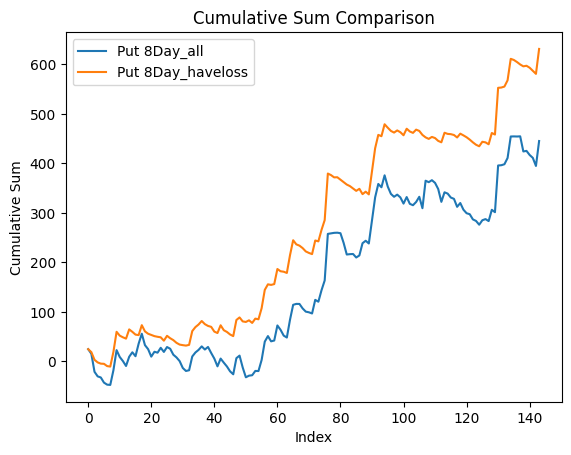

In [43]:
import matplotlib.pyplot as plt

# 繪製三條折線
new_stock_list['cumsum1'].plot(label='Put 8Day_all')
new_stock_list['cumsum2'].plot(label='Put 8Day_haveloss')

# 添加標題和圖例
plt.title('Cumulative Sum Comparison')
plt.xlabel('Index')
plt.ylabel('Cumulative Sum')
plt.legend()

# 顯示圖表
plt.show()
